# Предсказание нагрузки в распределенной оптоволоконной сети

Для раскрытия данной темы был взят датасет с сайта kaggle\
https://www.kaggle.com/datasets/inancigdem/optical-interconnection-network

## О наборе данных
### Контекст
Этот набор данных содержит 640 измерений производительности, полученных в результате моделирования двумерной многопроцессорной сети оптических соединений. Все симуляции были выполнены с помощью программного обеспечения OPNET Modeler. Передача сообщений используется в качестве механизма связи, при котором любой процессор может отправить в сеть сообщение типа "точка-точка", предназначенное для любого другого процессора.

### Содержание
Краткое описание атрибутов приведено ниже. Пожалуйста, прочтите статью (https://doi.org/10.1007/s11227-015-1384-1 ) для получения подробного описания атрибутов.

Node Number: количество узлов в сети. (8х8 или 4х4)

Thread Number: количество потоков в каждом узле в начале моделирования.

Spatial Distribution: производительность сети оценивается с использованием рабочих нагрузок искусственного трафика. Были включены модели трафика Uniform (UN), Hot Region (HR), Bit reverse (BR) и Perfect Shuffle (PS).

Temporal Distribution: временное распределение генерации пакетов реализуется независимыми источниками трафика. В нашем моделировании мы использовали трафик клиент-сервер (т. е. серверный узел посылает пакеты в ответ на получение пакетов от клиентов) и асинхронный трафик (т. е. изначально все узлы генерируют трафик независимо от других; с течением времени трафик генерация в узлах источника/назначения зависит от получения сообщений от узлов назначения/назначения).

T/R: Время передачи сообщения (T ). Равномерно распределено со средним значением в диапазоне от 20 до 100 тактовых циклов. Время выполнения потока (R) Распределено экспоненциально со средним значением 100 тактов

Processor Utilization: Среднее использование процессора измеряет процент времени, в течение которого потоки выполняются в процессоре

Channel Waiting Time: среднее время ожидания пакета в очереди выходного канала до тех пор, пока он не будет обслужен каналом

Input Waiting Time: среднее время ожидания пакета до тех пор, пока он не будет обслужен процессором

Network Response Time: время между помещением сообщения запроса в очередь на выходном канале и получением соответствующего сообщения данных во входной очереди

Channel Utilization: процент времени, в течение которого канал занят передачей пакетов в сеть

# Начало работы

### Импортируем библиотеки

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Сразу отбросим нежелательные сообщения, не влияющие на работу

In [5]:
import warnings
warnings.filterwarnings('ignore')

# 1. Предварительный анализ

### Чтение данных из файла

Сохраняем исходный датасет и копируем данные оттуда в датафрейм, с которым будет работать в дальнейшем

In [6]:
df = pd.read_csv("optical_interconnection_network.csv")
df.drop(columns=['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'], inplace = True)
df.head()

,Node Number,Thread Number,Spatial Distribution,Temporal Distribution,T/R,Processor Utilization,Channel Waiting Time,Input Waiting Time,Network Response Time,Channel Utilization
0,64,4,UN,Client-Server,"0,1","0,839546","1,974686","308,491814","700,514102","0,352431"
1,64,4,UN,Client-Server,"0,2","0,827412","9,556437","291,037663","864,599227","0,506302"
2,64,4,UN,Client-Server,"0,3","0,802605","27,027618","264,928002","839,372851","0,638516"
3,64,4,UN,Client-Server,"0,4","0,723403","61,848511","235,776888","1256,053108","0,767051"
4,64,4,UN,Client-Server,"0,5","0,72121","121,085884","189,680044","1343,875577","0,807812"


Сразу отбросим пустые столбцы

## Изучение структуры данных

Необходимо понять, как устроены данные, какие атрибуты присутствуют в наборе данных, и как они взаимодействуют друг с другом. Для этого могут использоваться различные инструменты, такие как статистические показатели, графики и визуализации.

### Статистические показатели

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Node Number             640 non-null    int64 
 1   Thread Number           640 non-null    int64 
 2   Spatial Distribution    640 non-null    object
 3   Temporal Distribution   640 non-null    object
 4   T/R                     640 non-null    object
 5   Processor Utilization   640 non-null    object
 6   Channel Waiting Time    640 non-null    object
 7   Input Waiting Time      640 non-null    object
 8   Network Response Time   640 non-null    object
 9   Channel Utilization     640 non-null    object
dtypes: int64(2), object(8)
memory usage: 50.1+ KB


In [8]:
df.describe()

,Node Number,Thread Number
count,640.000000,640.000000
mean,40.000000,7.000000
std,24.018772,2.237817
min,16.000000,4.000000
25%,16.000000,5.500000
50%,40.000000,7.000000
75%,64.000000,8.500000
max,64.000000,10.000000


In [9]:
for column in df.columns:
    print(column, '\n', df[column].value_counts())

Node Number 
 64    320
16    320
Name: Node Number, dtype: int64
Thread Number 
 4     160
6     160
8     160
10    160
Name: Thread Number, dtype: int64
Spatial Distribution 
 UN    160
HR    160
BR    160
PS    160
Name: Spatial Distribution, dtype: int64
Temporal Distribution 
 Client-Server    320
Asynchronous     320
Name: Temporal Distribution, dtype: int64
T/R 
 0,1    64
0,2    64
0,3    64
0,4    64
0,5    64
0,6    64
0,7    64
0,8    64
0,9    64
1      64
Name: T/R, dtype: int64
Processor Utilization  
 0,90698     2
0,531937    2
0,490711    2
0,505995    2
0,787135    2
           ..
0,416491    1
0,40539     1
0,398521    1
0,397512    1
0,515257    1
Name: Processor Utilization , Length: 624, dtype: int64
Channel Waiting Time 
 1,974686       1
9,556437       1
35,075058      1
103,896408     1
300,255798     1
              ..
156,048096     1
380,817383     1
504,747375     1
660,401001     1
1184,647461    1
Name: Channel Waiting Time, Length: 640, dtype: int64
Inp

Видим, что первые 4 признака категориальные

In [10]:
df.shape

(640, 10)

### Визуализация данных

Графики распределения (гистограмма/столбчатая диаграмма) отобранных столбцов

До начала визуализации необходимо конвертировать строчный тип данных в числовой

In [11]:
type(df['T/R'][0])

str

In [12]:
df['T/R'] = df['T/R'].str.replace(',', '.').astype(float)
df['Processor Utilization '] = df['Processor Utilization '].str.replace(',', '.').astype(float)
df['Channel Waiting Time'] = df['Channel Waiting Time'].str.replace(',', '.').astype(float)
df['Input Waiting Time'] = df['Input Waiting Time'].str.replace(',', '.').astype(float)
df['Network Response Time'] = df['Network Response Time'].str.replace(',', '.').astype(float)
df['Channel Utilization'] = df['Channel Utilization'].str.replace(',', '.').astype(float)

In [13]:
type(df['T/R'][0])

numpy.float64

И заменим названия столбцов

In [14]:
df.rename(columns={'Processor Utilization ': 'Processor_Utilization',
                    'Channel Waiting Time':'Channel_Waiting_Time',
                    'Node Number':'Node_Number',
                    'Thread Number':'Thread_Number',
                    'Spatial Distribution':'Spatial_Distribution',
                    'Temporal Distribution':'Temporal_Distribution',
                    'T/R':'T_R',
                    'Input Waiting Time':'Input_Waiting_Time',
                   'Network Response Time':'Network_Response_Time',
                   'Channel Utilization':'Channel_Utilization'
                  }, inplace=True)

In [15]:
df.columns

Index(['Node_Number', 'Thread_Number', 'Spatial_Distribution',
       'Temporal_Distribution', 'T_R', 'Processor_Utilization',
       'Channel_Waiting_Time', 'Input_Waiting_Time', 'Network_Response_Time',
       'Channel_Utilization'],
      dtype='object')

Существует встроенная в seaborn функция визуализирующая график распределения признаков

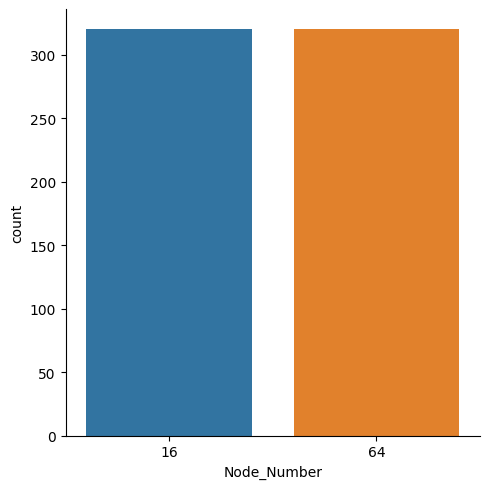

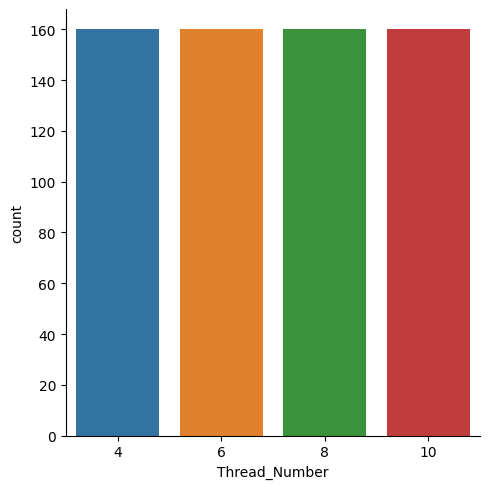

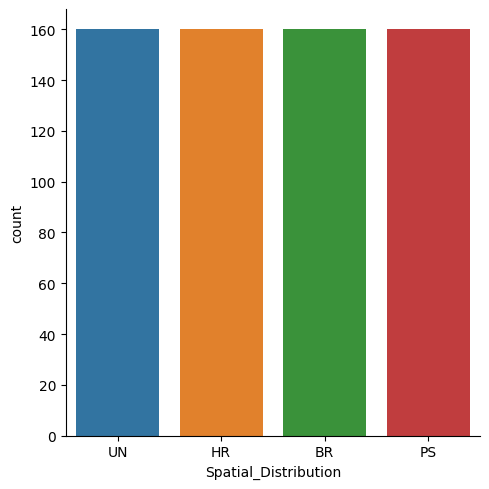

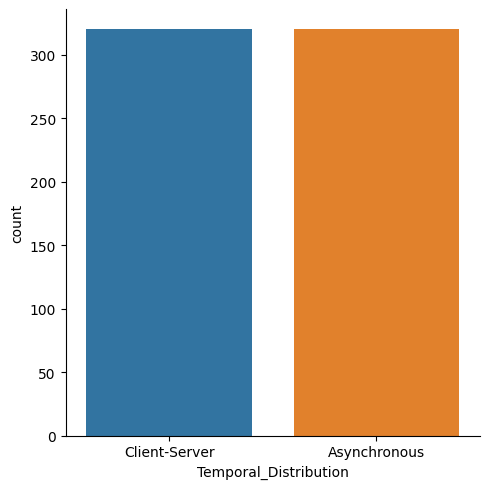

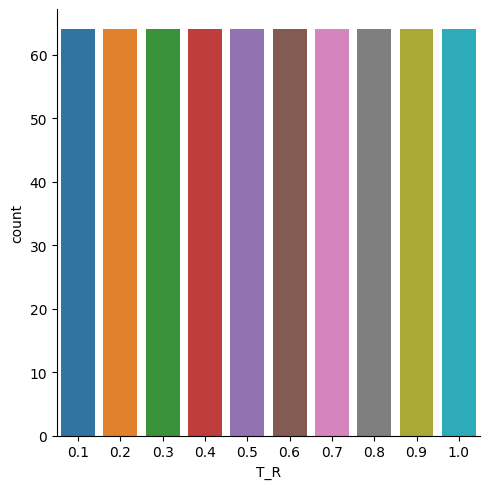

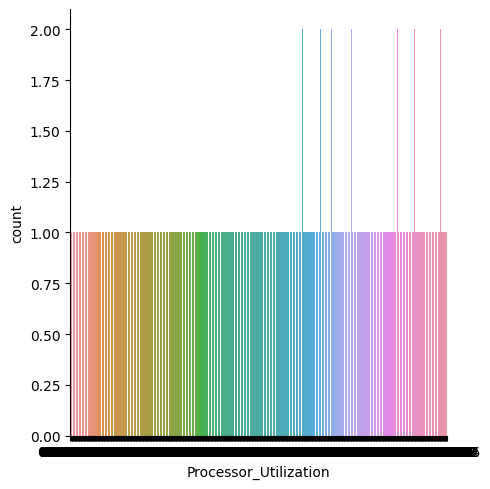

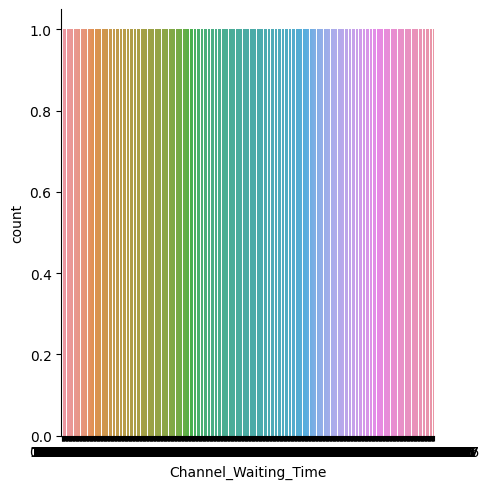

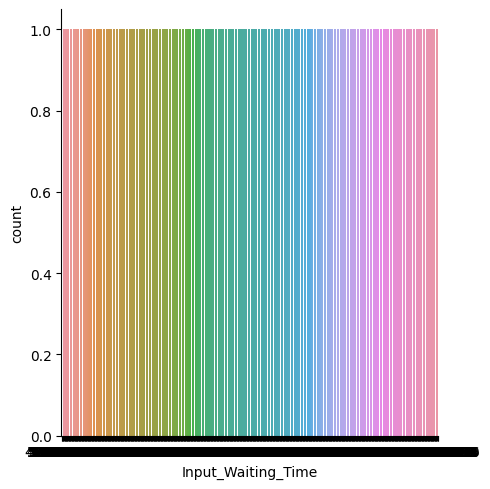

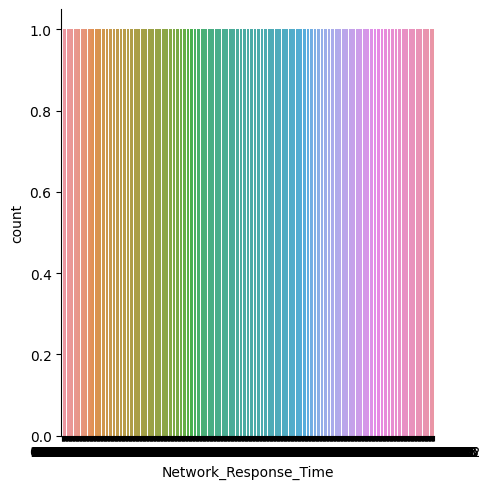

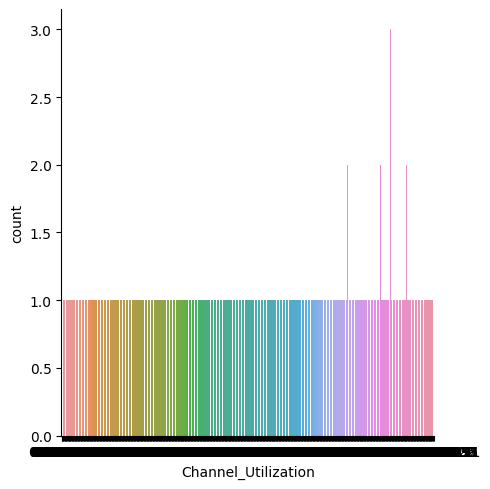

In [16]:
import seaborn as sns

for column in df.columns:
    sns.catplot(data=df, x=column, kind="count")
    plt.show()

Существует встроенная в matplotlib функция визуализирующая график распределения признаков

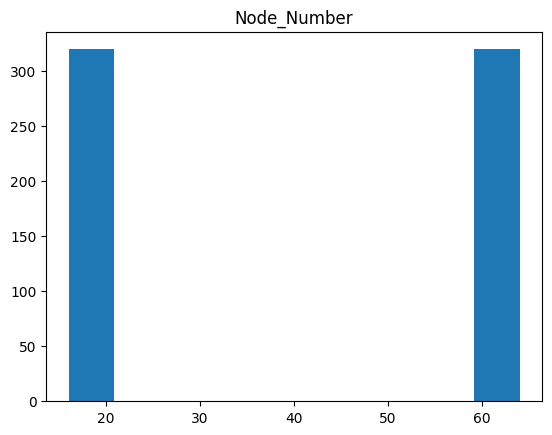

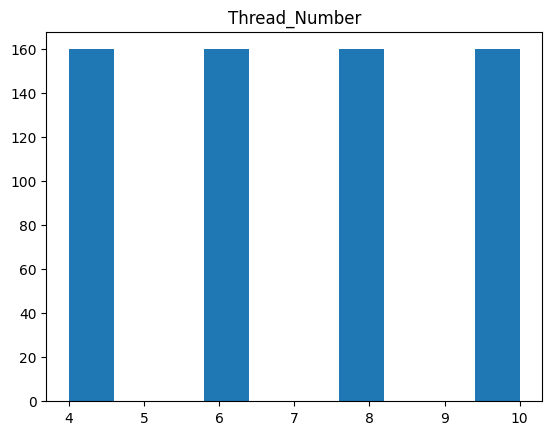

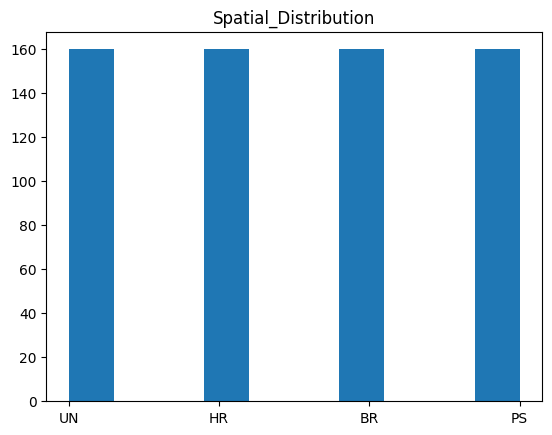

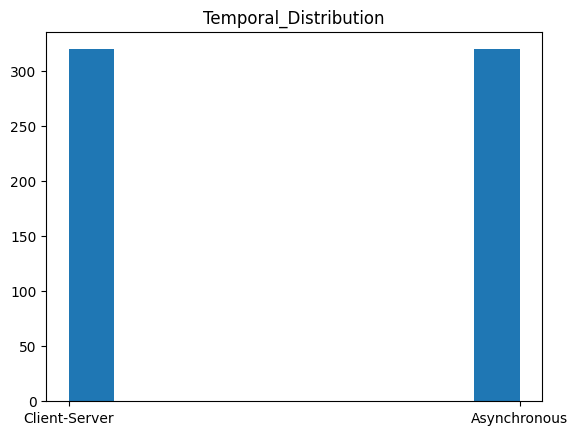

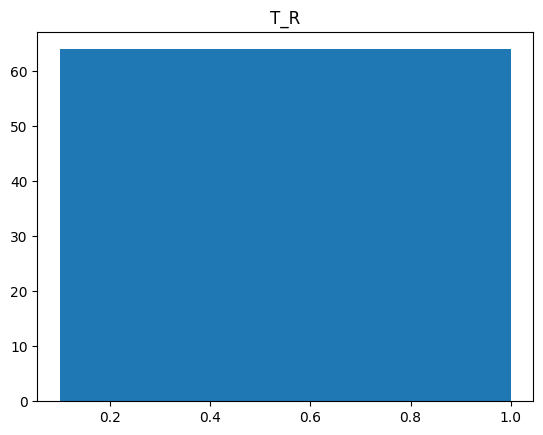

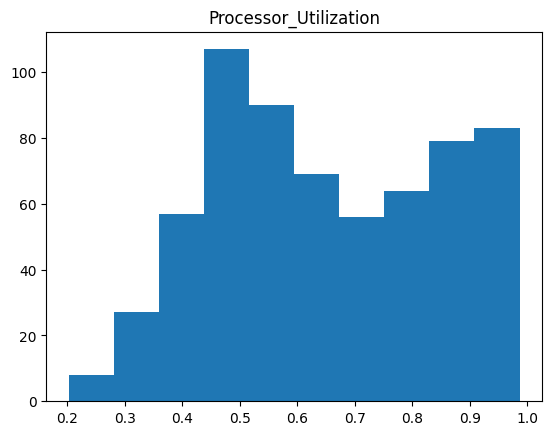

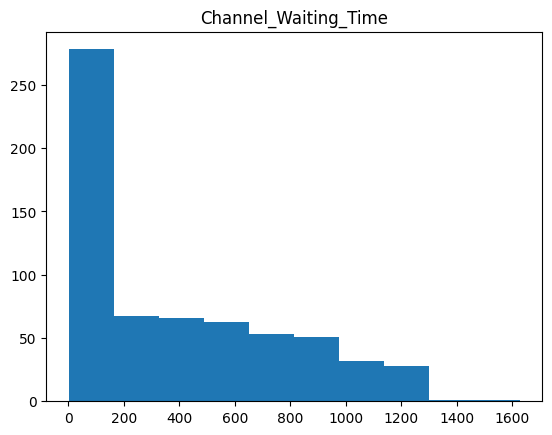

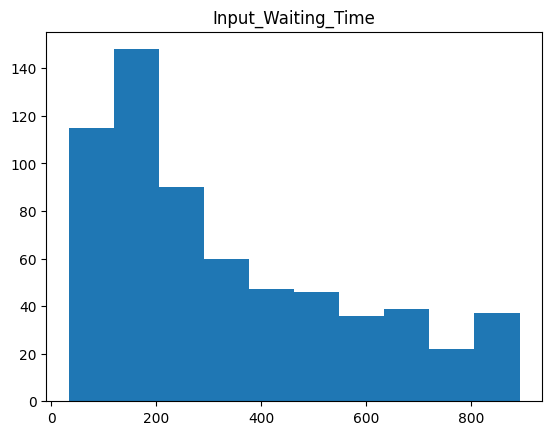

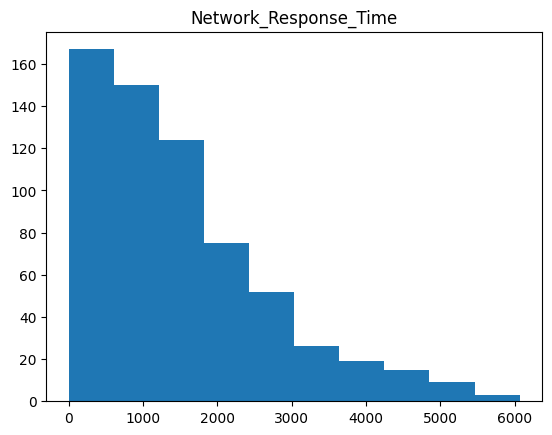

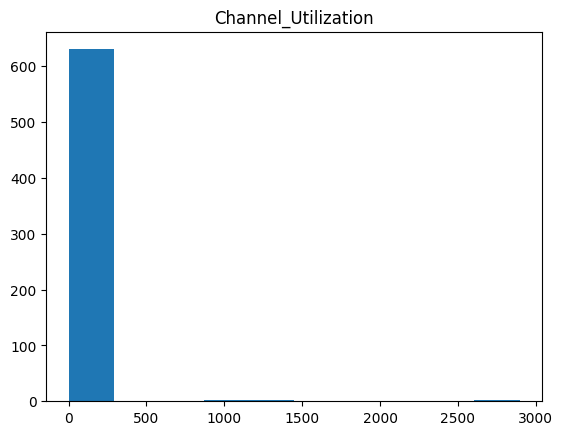

In [17]:
import matplotlib.pyplot as plt

for column in df.columns:
    plt.hist(df[column])
    plt.title(column)
    plt.show()

#### Графики по признакам

In [18]:
df.head()

,Node_Number,Thread_Number,Spatial_Distribution,Temporal_Distribution,T_R,Processor_Utilization,Channel_Waiting_Time,Input_Waiting_Time,Network_Response_Time,Channel_Utilization
0,64,4,UN,Client-Server,0.1,0.839546,1.974686,308.491814,700.514102,0.352431
1,64,4,UN,Client-Server,0.2,0.827412,9.556437,291.037663,864.599227,0.506302
2,64,4,UN,Client-Server,0.3,0.802605,27.027618,264.928002,839.372851,0.638516
3,64,4,UN,Client-Server,0.4,0.723403,61.848511,235.776888,1256.053108,0.767051
4,64,4,UN,Client-Server,0.5,0.721210,121.085884,189.680044,1343.875577,0.807812


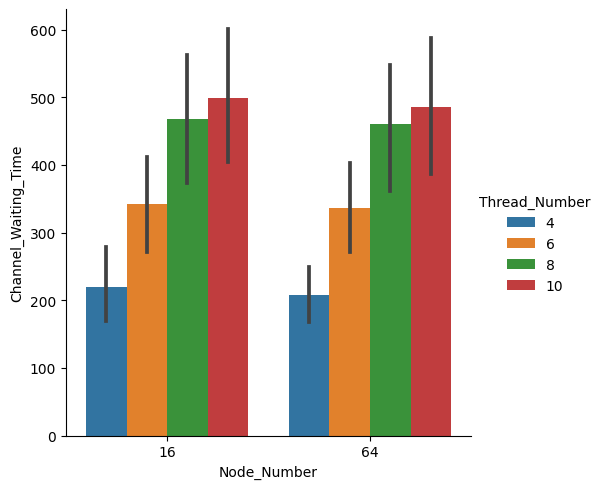

In [19]:
sns.catplot(data=df, x="Node_Number", y="Channel_Waiting_Time", hue="Thread_Number", kind="bar")
plt.show()

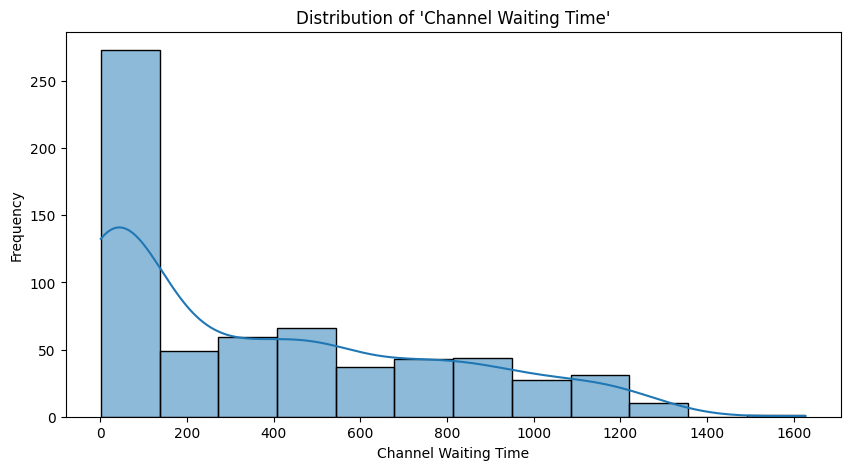

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(df['Channel_Waiting_Time'], kde=True)
plt.title("Distribution of 'Channel Waiting Time'")
plt.xlabel("Channel Waiting Time")
plt.ylabel("Frequency")
plt.show()

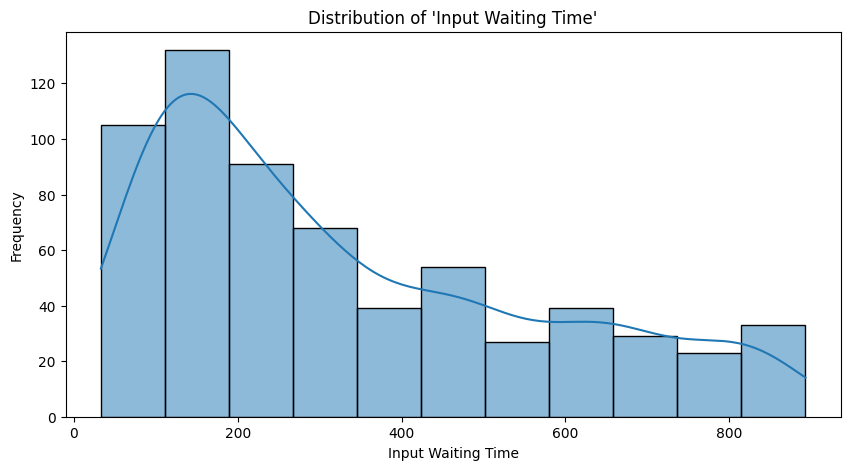

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(df['Input_Waiting_Time'], kde=True)
plt.title("Distribution of 'Input Waiting Time'")
plt.xlabel("Input Waiting Time")
plt.ylabel("Frequency")
plt.show()

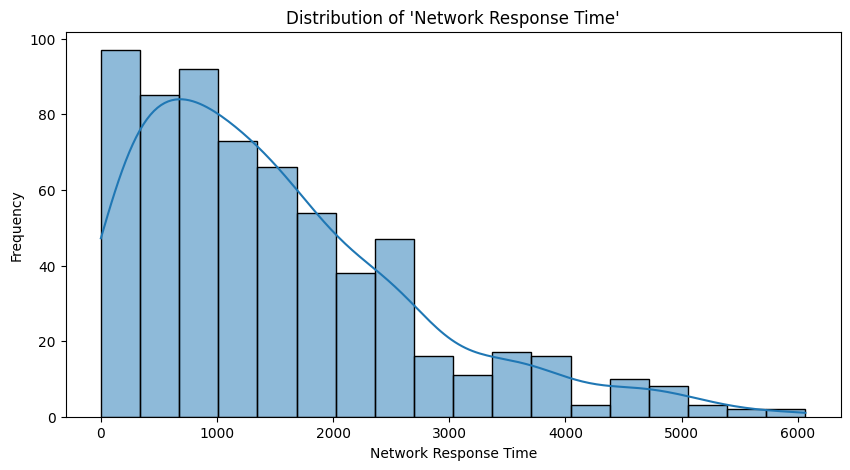

In [22]:
plt.figure(figsize=(10,5))
sns.histplot(df['Network_Response_Time'], kde=True)
plt.title("Distribution of 'Network Response Time'")
plt.xlabel("Network Response Time")
plt.ylabel("Frequency")
plt.show()

## Оценка качества данныx

Необходимо проверить данные на наличие ошибок, пропусков, выбросов, дубликатов и других проблем. Если такие проблемы обнаружены, их нужно решить до начала обучения.

### Проверка наличия пропусков данных

В библиотеке pandas для проверки наличия пропущенных значений можно использовать метод isna() для DataFrame или Series. Метод isna() возвращает булеву маску, где True означает наличие пропущенного значения.

In [23]:
df.nunique() # количество уникальных значений в каждом столбце

Node_Number                2
Thread_Number              4
Spatial_Distribution       4
Temporal_Distribution      2
T_R                       10
Processor_Utilization    624
Channel_Waiting_Time     640
Input_Waiting_Time       640
Network_Response_Time    640
Channel_Utilization      627
dtype: int64

In [24]:
df.isna().sum(axis=0) # пропущенные значения

Node_Number              0
Thread_Number            0
Spatial_Distribution     0
Temporal_Distribution    0
T_R                      0
Processor_Utilization    0
Channel_Waiting_Time     0
Input_Waiting_Time       0
Network_Response_Time    0
Channel_Utilization      0
dtype: int64

Пропущенные значения отсутствуют

### Изучение выбросов

Эта функция определяет диапазон выбросов для заданного столбца в данных.
Она вычисляет первый квартиль (25-й перцентиль), третий квартиль (75-й перцентиль) и межквартильный размах (IQR), а затем вычисляет нижнюю и верхнюю границы диапазона выбросов, используя множитель (по умолчанию 1.5).

Функция также выводит количество строк, которые будут затронуты выбросами и возвращает значения нижней и верхней границ диапазона выбросов.

In [25]:
df.head()

,Node_Number,Thread_Number,Spatial_Distribution,Temporal_Distribution,T_R,Processor_Utilization,Channel_Waiting_Time,Input_Waiting_Time,Network_Response_Time,Channel_Utilization
0,64,4,UN,Client-Server,0.1,0.839546,1.974686,308.491814,700.514102,0.352431
1,64,4,UN,Client-Server,0.2,0.827412,9.556437,291.037663,864.599227,0.506302
2,64,4,UN,Client-Server,0.3,0.802605,27.027618,264.928002,839.372851,0.638516
3,64,4,UN,Client-Server,0.4,0.723403,61.848511,235.776888,1256.053108,0.767051
4,64,4,UN,Client-Server,0.5,0.721210,121.085884,189.680044,1343.875577,0.807812


Строим ящик с усами для числовых признаков

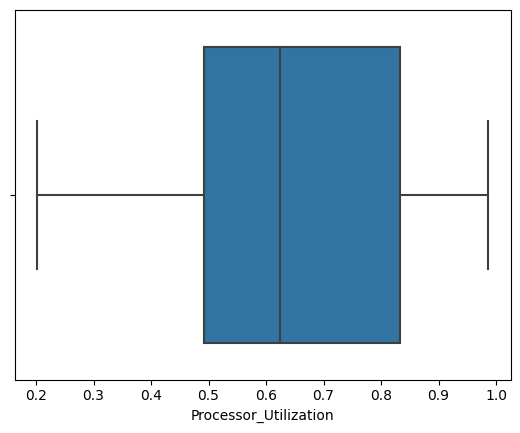

In [26]:
sns.boxplot(data=df, x="Processor_Utilization")
plt.show()

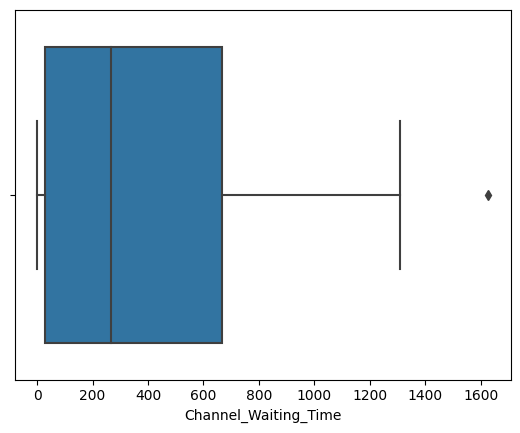

In [27]:
sns.boxplot(data=df, x="Channel_Waiting_Time")
plt.show()

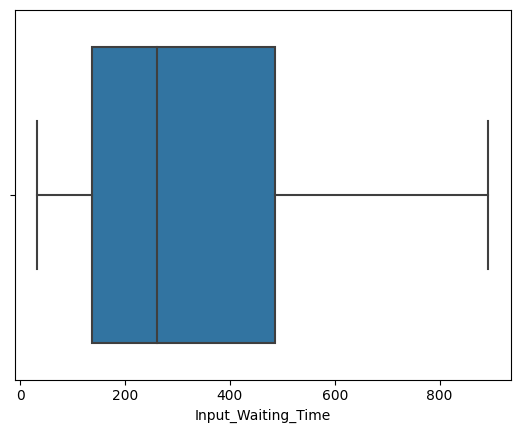

In [28]:
sns.boxplot(data=df, x="Input_Waiting_Time")
plt.show()

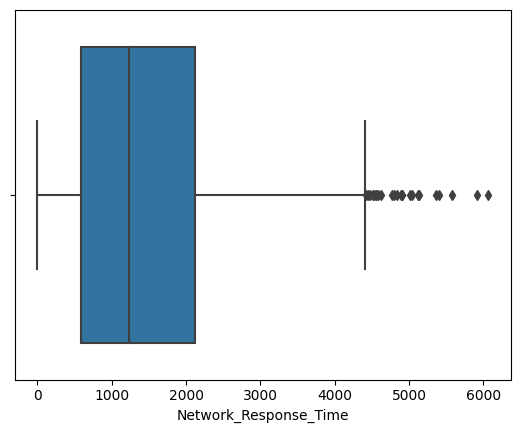

In [29]:
sns.boxplot(data=df, x="Network_Response_Time")
plt.show()

In [30]:
# Определим диапазон выбросов
def get_clean(df, column):
    # Определяем первый и третий квартили и межквартильный размах
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    # Определяем границы выбросов на основе межквартильного размаха
    lower = q1-iqr*1.5
    upper = q3+iqr*1.5

    # Отбираем только те строки, где значение столбца column находится внутри границ выбросов
    df_clean = df[(upper>=df[column]) & (lower<=df[column])]

    # Возвращаем новый датафрейм без выбросов
    return df_clean

In [31]:
df.Channel_Utilization.shape

(640,)

In [32]:
a = get_clean(df, "Channel_Utilization")
a

,Node_Number,Thread_Number,Spatial_Distribution,Temporal_Distribution,T_R,Processor_Utilization,Channel_Waiting_Time,Input_Waiting_Time,Network_Response_Time,Channel_Utilization
0,64,4,UN,Client-Server,0.1,0.839546,1.974686,308.491814,700.514102,0.352431
1,64,4,UN,Client-Server,0.2,0.827412,9.556437,291.037663,864.599227,0.506302
2,64,4,UN,Client-Server,0.3,0.802605,27.027618,264.928002,839.372851,0.638516
3,64,4,UN,Client-Server,0.4,0.723403,61.848511,235.776888,1256.053108,0.767051
4,64,4,UN,Client-Server,0.5,0.721210,121.085884,189.680044,1343.875577,0.807812
...,...,...,...,...,...,...,...,...,...,...
635,16,10,PS,Asynchronous,0.6,0.792340,532.737732,363.094043,1214.057768,0.961042
636,16,10,PS,Asynchronous,0.7,0.707199,751.675110,224.638088,1653.736882,0.981944
637,16,10,PS,Asynchronous,0.8,0.618230,905.326843,206.922631,1421.304936,0.962500
638,16,10,PS,Asynchronous,0.9,0.564482,1048.269897,154.713952,2371.043062,0.979375


In [33]:
a.shape

(630, 10)

Хоть выбросы и присутствуют, я бы не стал их удалять, потому что это довольно значимая часть данных

### Заполнение пропущенных значений

Пропущенные значения (missing values) в датасете могут возникать по разным причинам: ошибки сбора данных, ошибки при вводе данных, данные не предоставлены, данные потеряны и т.д. Наличие пропущенных значений в датасете может привести к некорректным результатам анализа данных, поэтому важно обработать эти пропущенные значения.

Существует несколько методов заполнения пропущенных значений в датасете:

Удаление строк или столбцов с пропущенными значениями: данный метод можно использовать, если пропущенные значения не занимают большую долю в датасете. Однако при этом может потеряться много информации.

Заполнение средним значением: данный метод можно использовать для числовых данных. Пропущенные значения заменяются на среднее значение по столбцу. Однако при использовании этого метода важно учитывать распределение данных и возможные выбросы.

Заполнение медианой: данный метод также можно использовать для числовых данных. Пропущенные значения заменяются на медианное значение по столбцу. Этот метод более устойчив к выбросам, чем метод среднего значения.

Заполнение модой: данный метод можно использовать для категориальных данных. Пропущенные значения заменяются на моду по столбцу, то есть на наиболее часто встречающееся значение.

Использование моделей машинного обучения: можно использовать модели машинного обучения для заполнения пропущенных значений. Например, можно обучить модель регрессии для заполнения пропущенных числовых значений или модель классификации для заполнения пропущенных категориальных значений.

При выборе метода заполнения пропущенных значений важно учитывать тип данных, распределение данных, наличие выбросов и объем пропущенных значений.

В случае с категориальным признаком, наиболее простым решением, если пропущенные значения не составляют большинство признака, будет замена наиболее часто встречающимся значением

Ниже пример кода как можно заполнить данные с уже предобработанными некорректными пропущенными значениями

In [34]:
# example['A'].fillna(example['A'].mean()[0], inplace=True)

В случае с числовым признаком, если опять же, большая часть данных не пропущена, заполнить его среднем значением

Ниже пример кода как можно заполнить данные с уже предобработанными некорректными пропущенными значениями

In [35]:
# example['B'].fillna(example['B'].mode()[0], inplace=True)

#### Работа с пропущенными значениями

In [36]:
df.head()

,Node_Number,Thread_Number,Spatial_Distribution,Temporal_Distribution,T_R,Processor_Utilization,Channel_Waiting_Time,Input_Waiting_Time,Network_Response_Time,Channel_Utilization
0,64,4,UN,Client-Server,0.1,0.839546,1.974686,308.491814,700.514102,0.352431
1,64,4,UN,Client-Server,0.2,0.827412,9.556437,291.037663,864.599227,0.506302
2,64,4,UN,Client-Server,0.3,0.802605,27.027618,264.928002,839.372851,0.638516
3,64,4,UN,Client-Server,0.4,0.723403,61.848511,235.776888,1256.053108,0.767051
4,64,4,UN,Client-Server,0.5,0.721210,121.085884,189.680044,1343.875577,0.807812


In [37]:
df.isna().sum(axis=0) # пропущенные значения

Node_Number              0
Thread_Number            0
Spatial_Distribution     0
Temporal_Distribution    0
T_R                      0
Processor_Utilization    0
Channel_Waiting_Time     0
Input_Waiting_Time       0
Network_Response_Time    0
Channel_Utilization      0
dtype: int64

In [38]:
# df['A'].fillna(df['A'].mode()[0], inplace=True)
# df['B'].fillna(0, inplace=True) #0
# df['C'].fillna(df['C'].mean()[0], inplace=True)

Вставлять пропущенные значения не стоит, потому что их нет

## Исследование взаимосвязей

Необходимо исследовать взаимосвязи между переменными, чтобы определить, какие факторы оказывают влияние на целевую переменную. Для этого могут использоваться корреляционные матрицы, диаграммы рассеяния и другие графики.

### Матрица корреляции

Существует встроенная в seaborn функция визуализирующая матрицу корреляций признаков

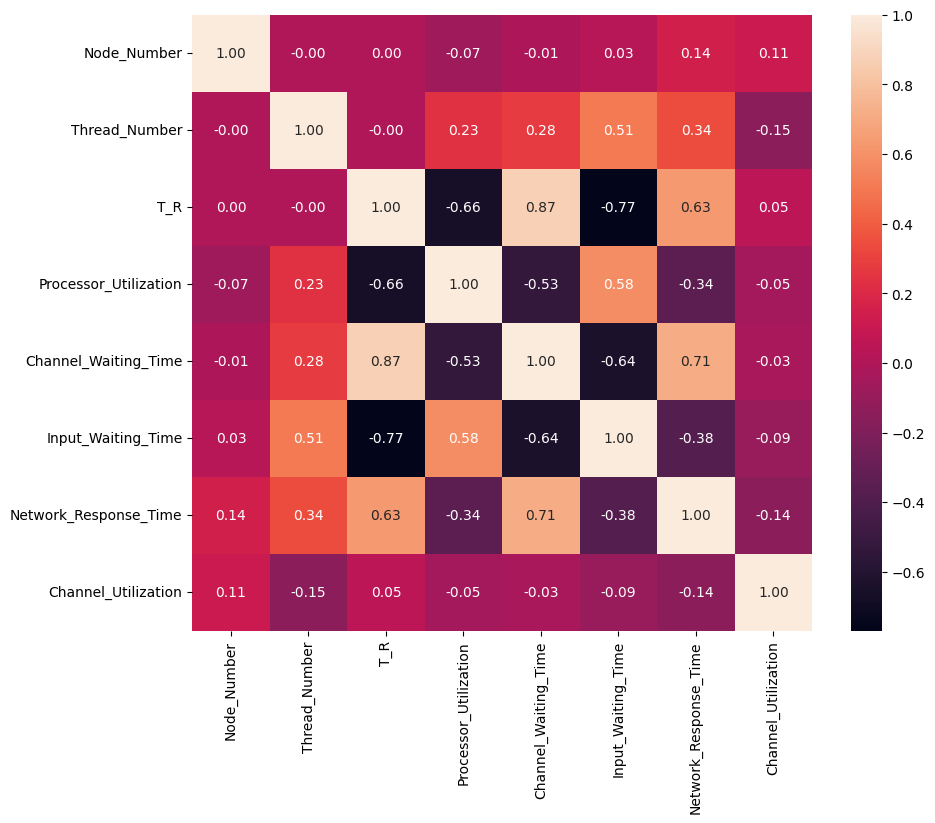

In [39]:
# Создание графика и задание его размеров
fig = plt.figure(figsize=(10, 8))

sns.heatmap(df.corr(), annot = True, fmt=".2f") # annot добавляет значение корреляции

# Отображение графика
plt.show()

### Диаграмма рассеяния

Существует встроенная в seaborn функция визуализирующая диаграму рассеяния признаков

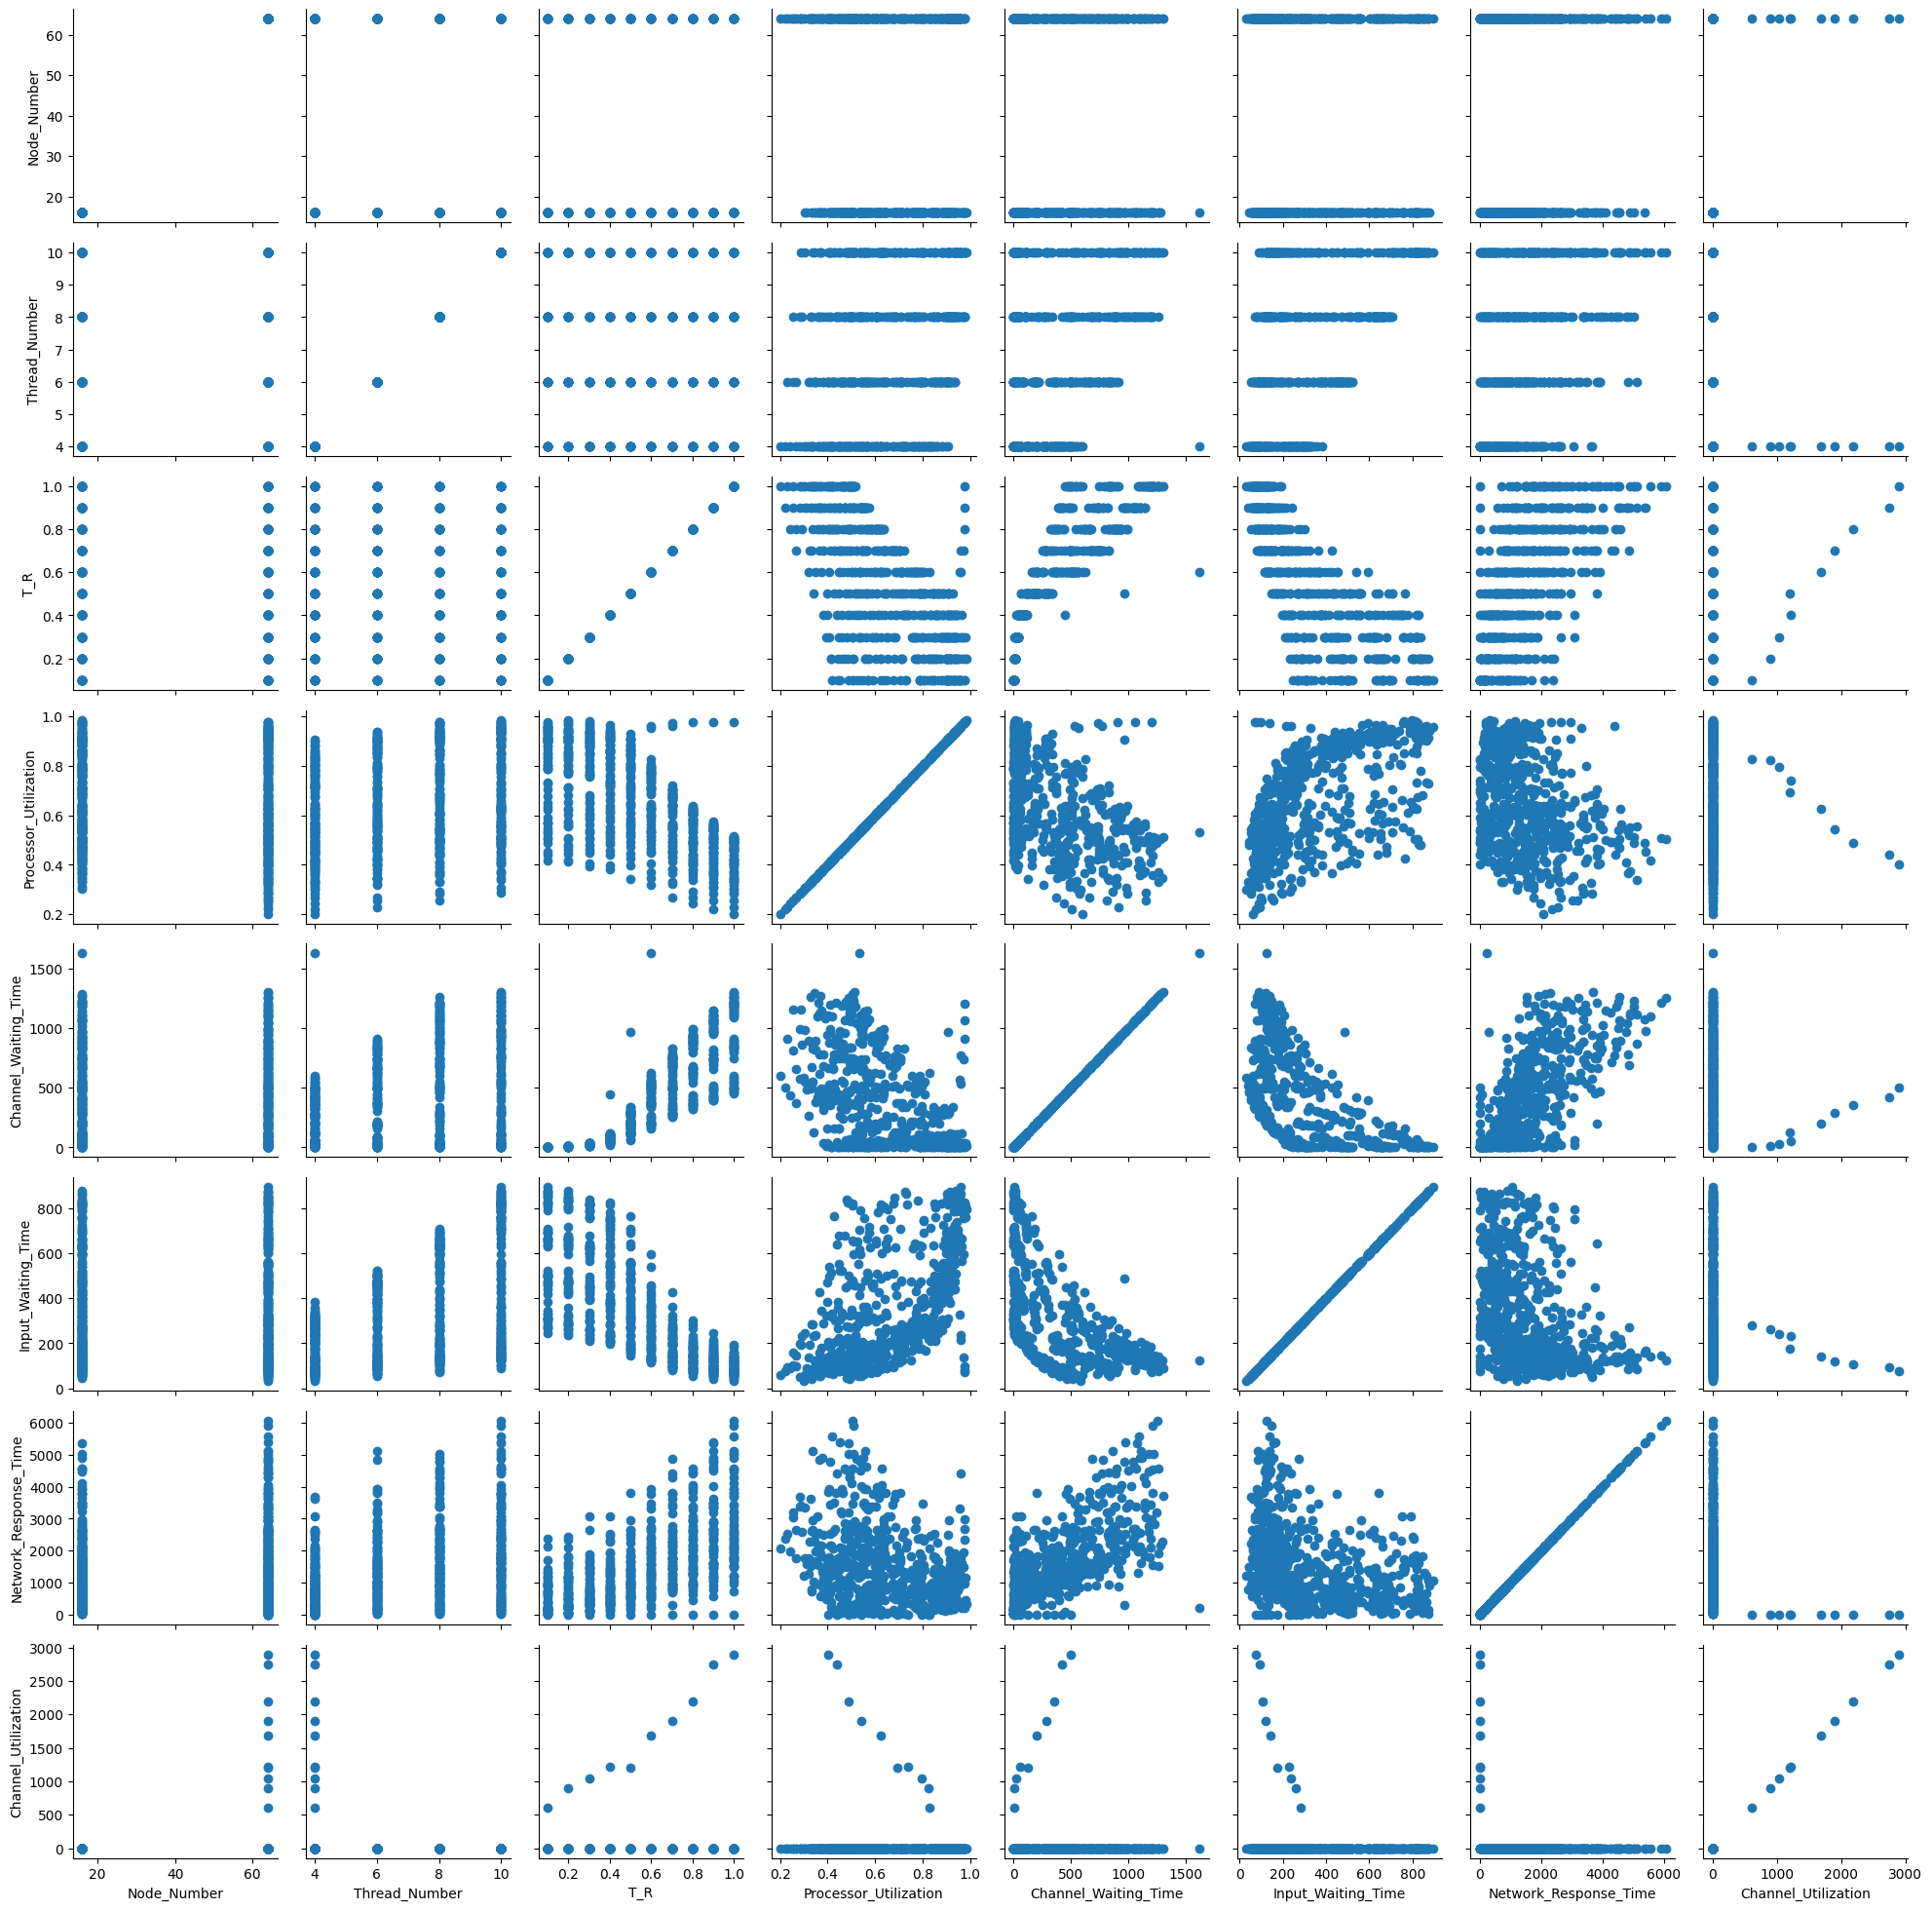

In [40]:
graph = sns.PairGrid(df) # строим сетку по 2 признакам для каждого столбца таблицы
graph.map(plt.scatter) # строим графики из точек для всех элементов списка
plt.show()

# 2. Предобработка данных

### Очистка данных (Data Cleaning)

Удаление отсутствующих значений (NaN), выбросов и дубликатов, исправление опечаток.



#### Удаление дубликатов

In [41]:
df = df.drop_duplicates()

#### Удаление отсутствующих значений

In [42]:
df = df.dropna()

### Кодирование категориальных данных (Categorical Data Encoding)

Преобразование категориальных данных (например, типа "город" или "страна") в числовой формат, который может быть использован алгоритмами машинного обучения.



Кодирование категориальных данных - это процесс преобразования категориальных признаков (например, цвет, марка, тип и т.д.) в числовой формат. Это необходимо, так как многие алгоритмы машинного обучения требуют, чтобы все признаки были числовыми. Существует несколько методов кодирования категориальных данных, и вот некоторые из них:

- Label Encoding (Кодирование меток) - это простой метод, который заключается в присвоении каждой уникальной категории целочисленного значения. Например, если у нас есть столбец "цвет" с категориями "красный", "синий" и "зеленый", то "красный" может быть закодирован как 1, "синий" как 2, а "зеленый" как 3.

- One-Hot Encoding (одноразрядное кодирование) - это метод, который создает новые бинарные признаки для каждой уникальной категории. Например, если у нас есть столбец "цвет" с категориями "красный", "синий" и "зеленый", то мы можем создать три новых признака: "цвет_красный", "цвет_синий" и "цвет_зеленый". Если строка содержит категорию "красный", то значение "цвет_красный" будет равно 1, а все остальные значения будут равны 0.

- Binary Encoding (двоичное кодирование) - это метод, который заключается в присвоении каждой уникальной категории целочисленного значения и дальнейшем представлении этого значения в бинарном формате. Например, если у нас есть столбец "цвет" с категориями "красный", "синий" и "зеленый", то "красный" может быть закодирован как 1 (0001 в бинарном формате), "синий" как 2 (0010 в бинарном формате), а "зеленый" как 3 (0100 в бинарном формате).

Кодирование категориальных данных является важной частью предварительной обработки данных в машинном обучении, и выбор метода кодирования зависит от конкретной задачи и характеристик данных.

### Перевод категориальных данных в числовые

In [43]:
new_df = df.copy()

In [44]:
df

,Node_Number,Thread_Number,Spatial_Distribution,Temporal_Distribution,T_R,Processor_Utilization,Channel_Waiting_Time,Input_Waiting_Time,Network_Response_Time,Channel_Utilization
0,64,4,UN,Client-Server,0.1,0.839546,1.974686,308.491814,700.514102,0.352431
1,64,4,UN,Client-Server,0.2,0.827412,9.556437,291.037663,864.599227,0.506302
2,64,4,UN,Client-Server,0.3,0.802605,27.027618,264.928002,839.372851,0.638516
3,64,4,UN,Client-Server,0.4,0.723403,61.848511,235.776888,1256.053108,0.767051
4,64,4,UN,Client-Server,0.5,0.721210,121.085884,189.680044,1343.875577,0.807812
...,...,...,...,...,...,...,...,...,...,...
635,16,10,PS,Asynchronous,0.6,0.792340,532.737732,363.094043,1214.057768,0.961042
636,16,10,PS,Asynchronous,0.7,0.707199,751.675110,224.638088,1653.736882,0.981944
637,16,10,PS,Asynchronous,0.8,0.618230,905.326843,206.922631,1421.304936,0.962500
638,16,10,PS,Asynchronous,0.9,0.564482,1048.269897,154.713952,2371.043062,0.979375


In [45]:
print("Node_Number: ", df['Node_Number'].unique())
print("Thread_Number: ", df['Thread_Number'].unique())
print("Spatial_Distribution: ", df['Spatial_Distribution'].unique())
print("Temporal_Distribution: ", df['Temporal_Distribution'].unique())

Node_Number:  [64 16]
Thread_Number:  [ 4  6  8 10]
Spatial_Distribution:  ['UN' 'HR' 'BR' 'PS']
Temporal_Distribution:  ['Client-Server' 'Asynchronous']


In [46]:
df['Temporal_Distribution'] = df['Temporal_Distribution'].apply(lambda x: 1 if x == 'Asynchronous' else 0)

In [47]:
df['Spatial_Distribution'].replace(to_replace = 'UN', value = 0, inplace = True)
df['Spatial_Distribution'].replace(to_replace = 'HR', value = 1, inplace = True)
df['Spatial_Distribution'].replace(to_replace = 'BR', value = 2, inplace = True)
df['Spatial_Distribution'].replace(to_replace = 'PS', value = 3, inplace = True)

In [48]:
df

,Node_Number,Thread_Number,Spatial_Distribution,Temporal_Distribution,T_R,Processor_Utilization,Channel_Waiting_Time,Input_Waiting_Time,Network_Response_Time,Channel_Utilization
0,64,4,0,0,0.1,0.839546,1.974686,308.491814,700.514102,0.352431
1,64,4,0,0,0.2,0.827412,9.556437,291.037663,864.599227,0.506302
2,64,4,0,0,0.3,0.802605,27.027618,264.928002,839.372851,0.638516
3,64,4,0,0,0.4,0.723403,61.848511,235.776888,1256.053108,0.767051
4,64,4,0,0,0.5,0.721210,121.085884,189.680044,1343.875577,0.807812
...,...,...,...,...,...,...,...,...,...,...
635,16,10,3,1,0.6,0.792340,532.737732,363.094043,1214.057768,0.961042
636,16,10,3,1,0.7,0.707199,751.675110,224.638088,1653.736882,0.981944
637,16,10,3,1,0.8,0.618230,905.326843,206.922631,1421.304936,0.962500
638,16,10,3,1,0.9,0.564482,1048.269897,154.713952,2371.043062,0.979375


#### Преобразование категориальных данных в числовой формат

In [49]:
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# df['A_encoded'] = label_encoder.fit_transform(df['A'])

#### Преобразование категориальных данных в бинарный формат

In [50]:
# new_df.drop(columns=['Segmentation', 'Profession', 'ID'], inplace = True)

In [51]:
new_df.head()

,Node_Number,Thread_Number,Spatial_Distribution,Temporal_Distribution,T_R,Processor_Utilization,Channel_Waiting_Time,Input_Waiting_Time,Network_Response_Time,Channel_Utilization
0,64,4,UN,Client-Server,0.1,0.839546,1.974686,308.491814,700.514102,0.352431
1,64,4,UN,Client-Server,0.2,0.827412,9.556437,291.037663,864.599227,0.506302
2,64,4,UN,Client-Server,0.3,0.802605,27.027618,264.928002,839.372851,0.638516
3,64,4,UN,Client-Server,0.4,0.723403,61.848511,235.776888,1256.053108,0.767051
4,64,4,UN,Client-Server,0.5,0.721210,121.085884,189.680044,1343.875577,0.807812


In [52]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
one_hot_encoded = pd.DataFrame(one_hot_encoder.fit_transform(new_df[['Spatial_Distribution']]).toarray(),
                                columns=one_hot_encoder.get_feature_names_out(['Spatial_Distribution']))
one_hot_encoded.reset_index(drop=True, inplace=True)
new_df.reset_index(drop=True, inplace=True)
a = pd.concat([new_df, one_hot_encoded], axis=1)

In [53]:
a

,Node_Number,Thread_Number,Spatial_Distribution,Temporal_Distribution,T_R,Processor_Utilization,Channel_Waiting_Time,Input_Waiting_Time,Network_Response_Time,Channel_Utilization,Spatial_Distribution_BR,Spatial_Distribution_HR,Spatial_Distribution_PS,Spatial_Distribution_UN
0,64,4,UN,Client-Server,0.1,0.839546,1.974686,308.491814,700.514102,0.352431,0.0,0.0,0.0,1.0
1,64,4,UN,Client-Server,0.2,0.827412,9.556437,291.037663,864.599227,0.506302,0.0,0.0,0.0,1.0
2,64,4,UN,Client-Server,0.3,0.802605,27.027618,264.928002,839.372851,0.638516,0.0,0.0,0.0,1.0
3,64,4,UN,Client-Server,0.4,0.723403,61.848511,235.776888,1256.053108,0.767051,0.0,0.0,0.0,1.0
4,64,4,UN,Client-Server,0.5,0.721210,121.085884,189.680044,1343.875577,0.807812,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,16,10,PS,Asynchronous,0.6,0.792340,532.737732,363.094043,1214.057768,0.961042,0.0,0.0,1.0,0.0
636,16,10,PS,Asynchronous,0.7,0.707199,751.675110,224.638088,1653.736882,0.981944,0.0,0.0,1.0,0.0
637,16,10,PS,Asynchronous,0.8,0.618230,905.326843,206.922631,1421.304936,0.962500,0.0,0.0,1.0,0.0
638,16,10,PS,Asynchronous,0.9,0.564482,1048.269897,154.713952,2371.043062,0.979375,0.0,0.0,1.0,0.0


pandas.get_dummies() - функция из библиотеки Pandas, которая создает фиктивные переменные для каждой уникальной категории в столбце категориальных данных. Например, если у нас есть столбец "Цвет", который может содержать значения "Красный", "Зеленый" и "Синий", функция get_dummies() создаст три новых столбца, каждый из которых будет иметь значения 0 или 1 в зависимости от того, какая категория была в исходном столбце.

In [54]:
new_df = pd.get_dummies(new_df)
new_df

,Node_Number,Thread_Number,T_R,Processor_Utilization,Channel_Waiting_Time,Input_Waiting_Time,Network_Response_Time,Channel_Utilization,Spatial_Distribution_BR,Spatial_Distribution_HR,Spatial_Distribution_PS,Spatial_Distribution_UN,Temporal_Distribution_Asynchronous,Temporal_Distribution_Client-Server
0,64,4,0.1,0.839546,1.974686,308.491814,700.514102,0.352431,0,0,0,1,0,1
1,64,4,0.2,0.827412,9.556437,291.037663,864.599227,0.506302,0,0,0,1,0,1
2,64,4,0.3,0.802605,27.027618,264.928002,839.372851,0.638516,0,0,0,1,0,1
3,64,4,0.4,0.723403,61.848511,235.776888,1256.053108,0.767051,0,0,0,1,0,1
4,64,4,0.5,0.721210,121.085884,189.680044,1343.875577,0.807812,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,16,10,0.6,0.792340,532.737732,363.094043,1214.057768,0.961042,0,0,1,0,1,0
636,16,10,0.7,0.707199,751.675110,224.638088,1653.736882,0.981944,0,0,1,0,1,0
637,16,10,0.8,0.618230,905.326843,206.922631,1421.304936,0.962500,0,0,1,0,1,0
638,16,10,0.9,0.564482,1048.269897,154.713952,2371.043062,0.979375,0,0,1,0,1,0


У нас получилось 2 датафрейма. Один с get_dummies, в другом мы просто заменили значения на численные

### Масштабирование данных (Data Scaling)

Приведение данных к одному масштабу (например, нормализация данных в диапазоне от 0 до 1 или стандартизация данных с нулевым средним и единичной дисперсией).



#### Нормализация данных в диапазоне от 0 до 1

Нормализация - это процесс приведения значений признаков к определенному диапазону. Это полезно, когда значения признаков сильно различаются по масштабу, например, один признак находится в диапазоне [0,1], а другой - в диапазоне [0, 10^5]. В таком случае модель может оказаться менее точной или сильно зависимой от одного из признаков.

Существует несколько методов нормализации:

- Min-max нормализация: каждое значение признака приводится к диапазону [0,1] путем вычитания минимального значения и деления на разность между максимальным и минимальным значениями. Формула: (x - min) / (max - min), где x - значение признака, min - минимальное значение признака, max - максимальное значение признака.

- Z-нормализация (стандартизация): каждое значение признака приводится к стандартному нормальному распределению с нулевым средним и единичной дисперсией. Формула: (x - mean) / std, где x - значение признака, mean - среднее значение признака, std - стандартное отклонение признака.

- Логарифмическая нормализация: каждое значение признака заменяется на его натуральный логарифм. Это может быть полезно, когда значения признаков имеют экспоненциальный рост.

- Другие методы нормализации включают в себя преобразование Бокса-Кокса и Yeo-Johnson.

Выбор метода нормализации зависит от конкретной задачи и типа данных. Некоторые модели, такие как нейронные сети, могут лучше работать с одним методом нормализации, чем с другим.

Нормализация используется в случаях, когда данные имеют различный масштаб и мы хотим, чтобы значения находились в одном и том же диапазоне. Например, это может быть полезно для методов машинного обучения, таких как k-ближайших соседей (k-NN), которые измеряют расстояние между объектами.

In [55]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [56]:
# from sklearn.preprocessing import normalize

# df = normalize(df)

#### Стандартизация данных

Стандартизация данных - это процесс приведения данных к определенному стандарту, который обеспечивает их согласованность и сопоставимость. Это может быть полезно во многих областях, где данные используются для анализа, обработки или хранения.

Одним из наиболее распространенных методов стандартизации данных является центрирование и масштабирование (Z-преобразование). Этот метод заключается в том, чтобы вычесть среднее значение всех значений из каждого значения и затем разделить на стандартное отклонение всех значений. Результатом являются данные со средним значением, равным нулю, и стандартным отклонением, равным единице.

Другой метод стандартизации данных - это мин-макс масштабирование. Этот метод заключается в приведении значений к интервалу между 0 и 1. Для этого каждое значение вычитается из минимального значения в наборе данных и затем делится на разницу между максимальным и минимальным значениями.

Кроме того, стандартизация может включать в себя такие операции, как преобразование типов данных, удаление дубликатов и пропущенных значений, агрегирование данных и приведение их к общей единице измерения.

Стандартизация обычно используется в случаях, когда данные имеют гауссово распределение, и мы хотим, чтобы каждый признак имел ту же дисперсию.

In [57]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

### Создание новых признаков (Feature Engineering)

Создание новых признаков на основе имеющихся данных, которые могут улучшить производительность модели.



Создание новых признаков на основе имеющихся данных является одним из важных шагов в подготовке данных для обучения модели машинного обучения. Новые признаки могут улучшить производительность модели, сделать ее более точной и улучшить ее способность к обобщению.

Новые признаки могут быть созданы на основе существующих признаков, например, путем объединения нескольких признаков в один или разбиением одного признака на несколько частей. Новые признаки могут также быть созданы на основе внешних данных, которые могут помочь расширить информационное пространство и улучшить способность модели к обобщению.

Примеры создания новых признаков:

- Создание нового признака, который показывает общее количество дней, прошедших с момента последнего визита пользователя на сайт до совершения им покупки.
- Создание нового признака, который описывает отношение площади квартиры к количеству комнат.
- Создание нового признака, который показывает среднюю стоимость товаров, купленных пользователем за последние 6 месяцев.

В целом, создание новых признаков является важным шагом в подготовке данных для машинного обучения, так как позволяет расширить обучающую выборку

In [58]:
# # создадим новый признак
# data['AB'] = data['A'] + data['B']

### Понижение размерности данных (Dimensionality Reduction)

Снижение количества признаков путем удаления ненужных или коррелирующих признаков или использование методов снижения размерности, таких как метод главных компонент (PCA).




PCA (Principal Component Analysis) - это метод анализа данных, который используется для снижения размерности набора данных путем преобразования его в новый набор переменных, называемый главными компонентами. Главные компоненты являются линейными комбинациями исходных переменных, которые максимизируют объясненную дисперсию данных.

Применение PCA может быть полезным во многих ситуациях, включая снижение размерности набора данных, устранение мультиколлинеарности, ускорение обучения моделей машинного обучения, уменьшение шума и улучшение визуализации данных.

Алгоритм PCA состоит из следующих шагов:

- Вычисление матрицы ковариации для исходного набора данных.
- Расчет собственных значений и собственных векторов матрицы ковариации.
- Сортировка собственных значений в порядке убывания и выбор первых k собственных векторов, соответствующих k самым большим собственным значениям.
- Проекция исходных данных на новое пространство признаков, построенное из выбранных собственных векторов.


In [59]:
# from sklearn.decomposition import PCA

# # применяем PCA для снижения размерности до двух признаков
# pca = PCA(n_components=2)
# data_raw_pca = pca.fit_transform(data_raw.data)

Понижаем размерность данных с помощью метода главных компонент

In [60]:
new_df.shape

(640, 14)

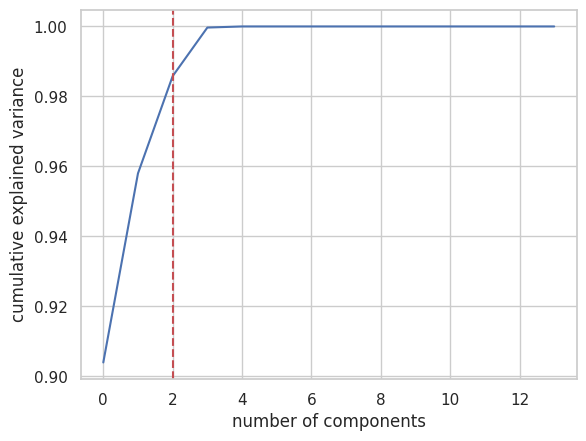

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.903942,9.039416e-01
1,0.957995,5.405353e-02
2,0.985801,2.780553e-02
3,0.999684,1.388318e-02
4,0.999999,3.152275e-04
5,0.999999,3.539549e-07
6,1.000000,2.057031e-07
7,1.000000,1.474313e-07
8,1.000000,1.353106e-07
9,1.000000,6.698397e-08


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pca_test = PCA(n_components=14)
pca_test.fit(new_df)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(2, color='r', linestyle = '--')
display(plt.show())

evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

воспользуемся PCA для уменьшения числа компонент с 20 до 2

In [62]:
pca = PCA(n_components=2)
pca.fit(new_df)
new_df_pca = pca.transform(new_df)

In [63]:
new_df_pca.shape

(640, 2)

Это преобразование позовляет строить визуализации данных, но при этом упускает часть информации изначальног датасета, поэтому в обучении лучше использовать неизмененную выборку

### Разделение данных (Data Splitting)

Разделение данных на тренировочную, валидационную и тестовую выборки.

Разделение данных - это процесс разделения набора данных на обучающую и тестовую выборки для обучения и оценки модели машинного обучения. Обучающая выборка используется для обучения модели, а тестовая выборка используется для проверки ее производительности на новых, ранее не виданных данных.

Обычно данные разделяют в пропорции 70/30, 80/20 или 90/10, где 70%, 80% или 90% данных используется для обучения, а остальные 30%, 20% или 10% данных используются для тестирования.

In [64]:
# from sklearn.model_selection import train_test_split

# # Деление на тренировочную и тестовую выборки
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
df

,Node_Number,Thread_Number,Spatial_Distribution,Temporal_Distribution,T_R,Processor_Utilization,Channel_Waiting_Time,Input_Waiting_Time,Network_Response_Time,Channel_Utilization
0,64,4,0,0,0.1,0.839546,1.974686,308.491814,700.514102,0.352431
1,64,4,0,0,0.2,0.827412,9.556437,291.037663,864.599227,0.506302
2,64,4,0,0,0.3,0.802605,27.027618,264.928002,839.372851,0.638516
3,64,4,0,0,0.4,0.723403,61.848511,235.776888,1256.053108,0.767051
4,64,4,0,0,0.5,0.721210,121.085884,189.680044,1343.875577,0.807812
...,...,...,...,...,...,...,...,...,...,...
635,16,10,3,1,0.6,0.792340,532.737732,363.094043,1214.057768,0.961042
636,16,10,3,1,0.7,0.707199,751.675110,224.638088,1653.736882,0.981944
637,16,10,3,1,0.8,0.618230,905.326843,206.922631,1421.304936,0.962500
638,16,10,3,1,0.9,0.564482,1048.269897,154.713952,2371.043062,0.979375


In [66]:
y = pd.DataFrame(df['Processor_Utilization'])
y.head()

,Processor_Utilization
0,0.839546
1,0.827412
2,0.802605
3,0.723403
4,0.721210


In [67]:
x = pd.DataFrame(df[['Node_Number', 'Thread_Number', 'Spatial_Distribution',
       'Temporal_Distribution', 'T_R',
       'Channel_Waiting_Time', 'Input_Waiting_Time', 'Network_Response_Time',
       'Channel_Utilization']])
x.head()

,Node_Number,Thread_Number,Spatial_Distribution,Temporal_Distribution,T_R,Channel_Waiting_Time,Input_Waiting_Time,Network_Response_Time,Channel_Utilization
0,64,4,0,0,0.1,1.974686,308.491814,700.514102,0.352431
1,64,4,0,0,0.2,9.556437,291.037663,864.599227,0.506302
2,64,4,0,0,0.3,27.027618,264.928002,839.372851,0.638516
3,64,4,0,0,0.4,61.848511,235.776888,1256.053108,0.767051
4,64,4,0,0,0.5,121.085884,189.680044,1343.875577,0.807812


In [68]:
from sklearn.preprocessing import normalize

x = normalize(x)

In [69]:
from sklearn.model_selection import train_test_split

# Деление на тренировочную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 3. Обучение моделей

## Классическое машинное обучение

Я взял несколько моделей для сравнения и занес их конечные метрики в единую сводную таблицу.

Формируем пустую сводную таблицу, чтобы потом заполнить ее значениями

In [70]:
scores = pd.DataFrame(
    columns=['mean_absolute_error', 'mean_squared_error', 'r2_score', 'explained_variance_score', 'duration'],
    index=[
        'LinearRegression',
        'DecisionTreeRegressor',
        'RandomForestRegressor',
        'GradientBoostingRegressor',
        'SVR.linear',
        'SVR.rbf',
        'MLPRegressor',
        'KNeighborsRegressor',
        'L1 regularization (Lasso)',
        'L2 regularization (Ridge)'
    ]
)

Функция для получения метрик качества моделей

In [71]:
from sklearn import metrics

def get_metrics(y_test, y_pred):
    mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
    mean_squared_error = metrics.mean_squared_error(y_test, y_pred)
    r2_score = metrics.r2_score(y_test, y_pred)
    explained_variance_score = metrics.explained_variance_score(y_test, y_pred)
    return pd.Series(
        (mean_absolute_error, mean_squared_error, r2_score, explained_variance_score),
        index=['mean_absolute_error', 'mean_squared_error', 'r2_score', 'explained_variance_score']
    )

Mean Absolute Error (MAE) - это метрика оценки качества модели в задачах регрессии. Она измеряет среднее абсолютное отклонение предсказанных значений от фактических значений целевой переменной.

Для вычисления MAE сначала вычисляются абсолютные значения разностей между предсказанными и фактическими значениями для каждого наблюдения. Затем берется среднее значение этих абсолютных разностей.

MAE позволяет оценить, насколько в среднем модель ошибается в предсказании значений целевой переменной. Чем меньше значение MAE, тем лучше модель. MAE выражается в тех же единицах, что и целевая переменная, что делает его легко интерпретируемым.

Mean Squared Error (MSE) - это метрика оценки качества модели в задачах регрессии. Она измеряет среднее значение квадратов разностей между предсказанными и фактическими значениями целевой переменной.

Для вычисления MSE сначала вычисляются квадраты разностей между предсказанными и фактическими значениями для каждого наблюдения. Затем берется среднее значение этих квадратов.

MSE позволяет оценить, насколько хорошо модель приближает фактические значения целевой переменной. Чем меньше значение MSE, тем лучше модель. MSE выражается в квадрате единицы целевой переменной, что делает его несколько сложнее интерпретируемым, чем MAE.

R2 Score (также известный как коэффициент детерминации) - это метрика оценки качества модели в задачах регрессии. Он измеряет пропорцию дисперсии целевой переменной, которая может быть объяснена моделью, по сравнению с общей дисперсией целевой переменной.

Значение R2 Score находится в диапазоне от 0 до 1. Значение 1 означает, что модель идеально объясняет вариацию в данных, а значение 0 означает, что модель не объясняет никакой вариации и ее предсказания равны среднему значению целевой переменной.

R2 Score можно интерпретировать как долю объясненной вариации в данных. Чем ближе значение R2 Score к 1, тем лучше модель объясняет данные. Значение R2 Score меньше 0 может указывать на то, что модель производит предсказания хуже, чем простое среднее значение.

Explained Variance Score (Оценка объясненной дисперсии) является метрикой оценки качества модели в задачах регрессии. Она измеряет пропорцию объясненной дисперсии моделью относительно общей дисперсии целевой переменной.

Значение Explained Variance Score также находится в диапазоне от 0 до 1. Значение 1 означает, что модель идеально объясняет всю дисперсию в данных, а значение 0 означает, что модель не объясняет никакую вариацию.

Explained Variance Score позволяет оценить, насколько хорошо модель справляется с объяснением вариации в данных. Чем ближе значение Explained Variance Score к 1, тем лучше модель объясняет данные. Значение ниже 0 может указывать на то, что модель предсказывает хуже, чем простое среднее значение целевой переменной.

Функция обучения и записи времени процесса обучения модели в секундах

In [72]:
import time
from sklearn.model_selection import learning_curve

In [73]:
def model_and_metrics(model):

    # начало обучения модели
    start = time.time()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    # конец обучения модели
    end = time.time()

    # # Получение коэффициентов регрессии
    # coefficients = model.coef_

    # # Вывод коэффициентов регрессии
    # for i, coefficient in enumerate(coefficients):
    #     print(f'Коэффициент для признака {i+1}: {coefficient}')

    # График обучения
    train_sizes, train_scores, valid_scores = learning_curve(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    valid_scores_mean = -np.mean(valid_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training')
    plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Validation')
    plt.xlabel('Training examples')
    plt.ylabel('Negative Mean Squared Error')
    plt.legend(loc='best')
    plt.show()

    duration = pd.Series([end - start])
    returned = pd.concat([get_metrics(y_test, y_pred), duration])
    return returned

### #1 Classic model (LinearRegression)

LinearRegression - это модель линейной регрессии в машинном обучении, которая пытается установить линейную зависимость между признаками и целевой переменной. Она представляет собой простую линейную модель, которая использует метод наименьших квадратов для нахождения коэффициентов, минимизирующих сумму квадратов разностей между предсказанными и реальными значениями.

Модель LinearRegression является одной из самых простых моделей в машинном обучении и может быть использована для различных задач регрессии. Например, она может использоваться для предсказания цен на недвижимость, доходов, расходов и т.д.

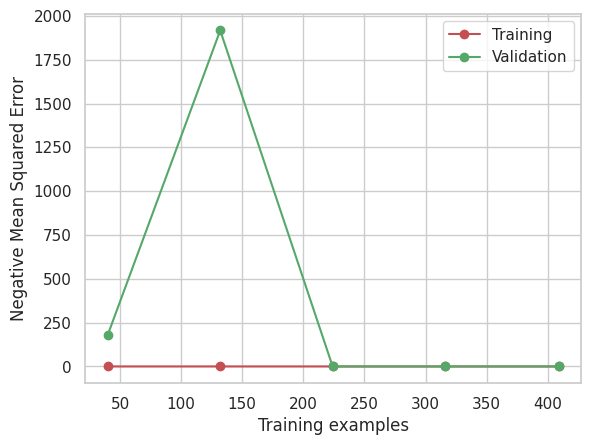

In [74]:
from sklearn.linear_model import LinearRegression

scores.iloc[0] = model_and_metrics(LinearRegression())

### #2 Classic model (DecisionTreeRegressor)

DecisionTreeRegressor - это модель решающего дерева для задачи регрессии. В отличие от линейной регрессии, DecisionTreeRegressor может захватывать нелинейные зависимости между признаками и целевой переменной. Она разбивает данные на более мелкие группы на основе разделения по признакам и значению порога, чтобы минимизировать среднеквадратическую ошибку (MSE) целевой переменной в каждой группе.

Дерево строится путем рекурсивного разделения данных на две или более подгруппы, пока не будет достигнут критерий остановки. Это может быть, например, достижение максимальной глубины дерева или минимального количества образцов в листовых узлах.

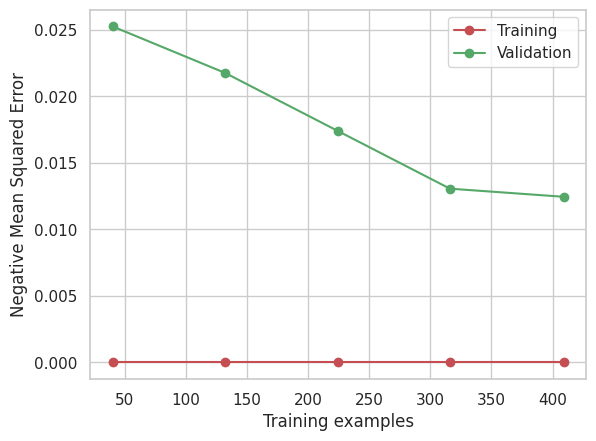

In [75]:
from sklearn.tree import DecisionTreeRegressor

scores.iloc[1] = model_and_metrics(DecisionTreeRegressor())

### #3 Classic model (RandomForestRegressor)

Random Forest Regressor (случайный лес регрессии) является одним из наиболее популярных алгоритмов машинного обучения для задач регрессии в области Data Science. Он является расширением алгоритма случайного леса (Random Forest) для задач регрессии.

Алгоритм Random Forest Regressor строит множество деревьев решений (набор решающих деревьев), каждое из которых обучается на случайной подвыборке исходных данных. При этом каждое дерево строится по определенному алгоритму и использует только некоторые из имеющихся признаков (случайный набор признаков).

В отличие от одного дерева решений, случайный лес регрессии устойчив к переобучению и дает более точные результаты при обучении на больших объемах данных. Он также обладает способностью обрабатывать данные с различными типами признаков (категориальные, числовые и т.д.).

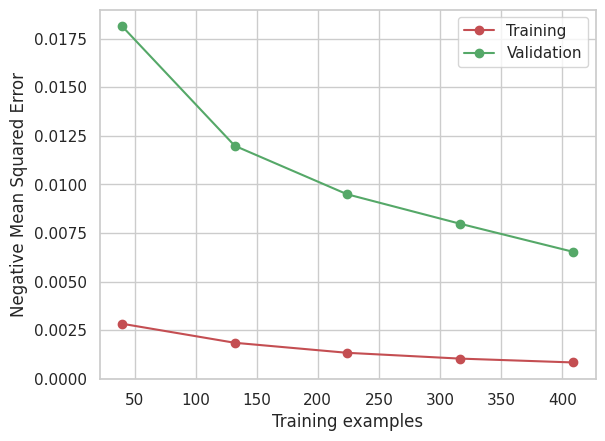

In [76]:
from sklearn.ensemble import RandomForestRegressor

scores.iloc[2] = model_and_metrics(RandomForestRegressor())

### #4 Classic model (GradientBoostingRegressor)

GradientBoostingRegressor - это алгоритм градиентного бустинга для задач регрессии. Он строит ансамбль деревьев решений и обучается путем итеративного улучшения прогноза модели.

Основной принцип работы GradientBoostingRegressor заключается в том, что на каждой итерации алгоритм обучает новое дерево, которое предсказывает остатки, полученные на предыдущей итерации. Таким образом, каждое следующее дерево учитывает ошибки предыдущего дерева и пытается уменьшить их. Идея заключается в том, что ансамбль моделей может получить лучший результат, чем отдельная модель.

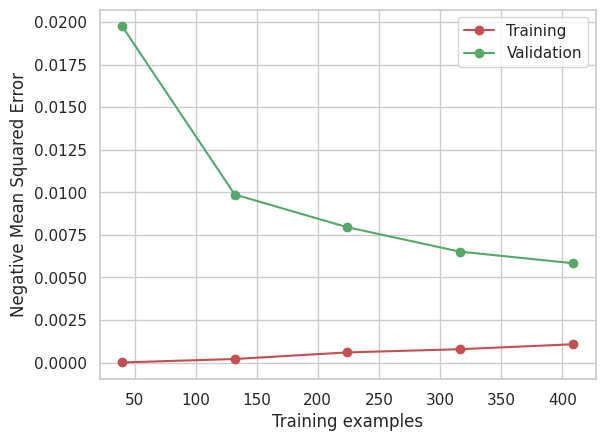

In [77]:
from sklearn.ensemble import GradientBoostingRegressor

scores.iloc[3] = model_and_metrics(GradientBoostingRegressor())

### #5 Classic model (SVR.linear)

SVR.linear - это модификация метода опорных векторов (SVM), применяемая для задач регрессии. В отличие от стандартного SVM, использующего ядра для преобразования данных, SVR.linear использует линейную функцию для построения гиперплоскости, разделяющей точки разных классов.

Для обучения модели используется метод оптимизации под названием "решающее правило". Задача заключается в том, чтобы минимизировать ошибку предсказания для каждого объекта в обучающем наборе. Для этого определяется метрика, называемая функцией потерь (loss function), которая измеряет, насколько сильно прогноз модели отличается от фактического значения.

SVR.linear также имеет гиперпараметры, которые могут быть настроены для достижения наилучшей производительности модели. Некоторые из этих гиперпараметров включают в себя коэффициент регуляризации С (C-параметр), а также параметр эпсилон, который управляет шириной зазора между разделяющей гиперплоскостью и ближайшими точками обучающего набора.

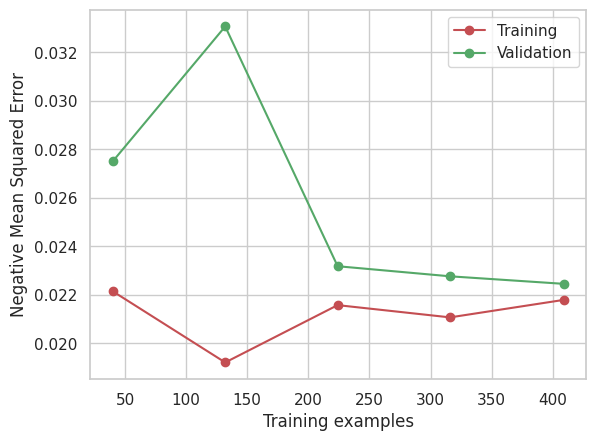

In [78]:
from sklearn.svm import SVR

scores.iloc[4] = model_and_metrics(SVR(kernel='linear'))

### #6 Classic model (SVR.rbf)

SVR.rbf (Radial Basis Function) является одной из версий метода опорных векторов для задачи регрессии. Он использует ядро RBF для построения модели.

RBF-ядро преобразует пространство признаков в более высокомерное пространство, где можно легко провести гиперплоскость, которая разделяет классы. Оно используется для нахождения оптимального разделения между классами в задачах классификации, а в задаче регрессии - для поиска оптимальной функции аппроксимации.

Главным параметром этого алгоритма является параметр С, который отвечает за баланс между ошибкой и сложностью модели. Также есть параметр gamma, который определяет, как быстро значения ядра уменьшаются с ростом расстояния от опорных векторов.

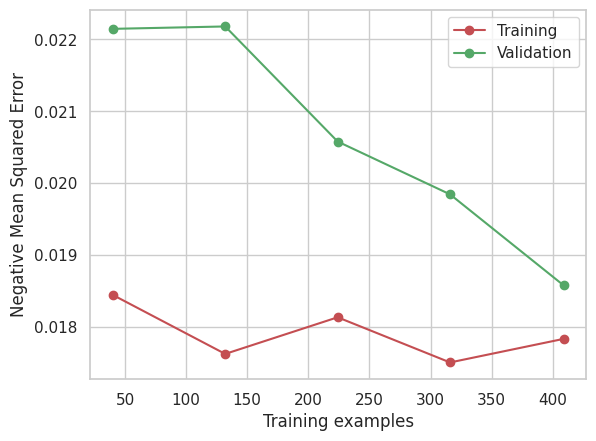

In [79]:
from sklearn.svm import SVR

scores.iloc[5] = model_and_metrics(SVR(kernel='rbf'))

### #7 Classic model (MLPRegressor)

MLPRegressor (Multi-layer Perceptron Regressor) - это модель искусственной нейронной сети прямого распространения для решения задачи регрессии. Она состоит из одного или нескольких скрытых слоев нейронов, соединенных взвешенными связями между нейронами, и выходного слоя, который генерирует предсказания.

В sklearn класс MLPRegressor реализует данную модель. Его гиперпараметры позволяют настраивать архитектуру сети, в том числе количество слоев, количество нейронов в каждом слое, функции активации и оптимизатор.

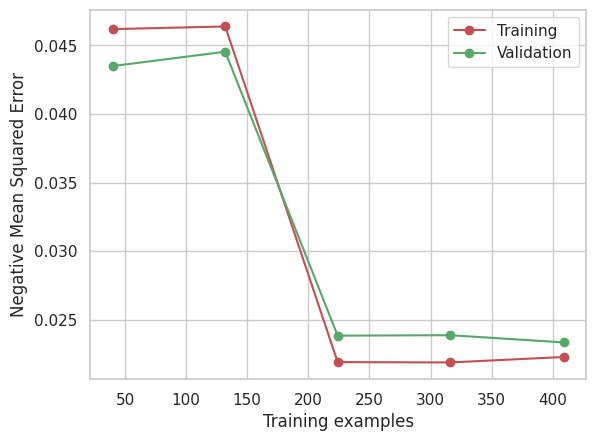

In [80]:
from sklearn.neural_network import MLPRegressor

scores.iloc[6] = model_and_metrics(MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42))

### #8 Classic model (KNeighborsRegressor)

KNeighborsRegressor - это модель машинного обучения, которая относится к семейству алгоритмов "ближайших соседей" (k-Nearest Neighbors, k-NN). Она используется для решения задач регрессии, то есть для предсказания числовых значений на основе сходства с ближайшими соседями в обучающем наборе данных.

Основная идея KNeighborsRegressor заключается в том, что близкие объекты имеют схожие значения целевой переменной. Алгоритм состоит из двух основных этапов: обучения и предсказания.

Во время обучения модели KNeighborsRegressor загружает данные в память и создает структуру данных, которая позволяет быстро находить ближайших соседей для каждого объекта. Для этого используется алгоритм kd-деревьев, который строит бинарное дерево поиска по признакам объектов.

Во время предсказания KNeighborsRegressor находит k ближайших соседей для каждого тестового объекта и использует их для предсказания значения целевой переменной. Значение целевой переменной предсказывается как среднее значение целевых переменных k ближайших соседей.

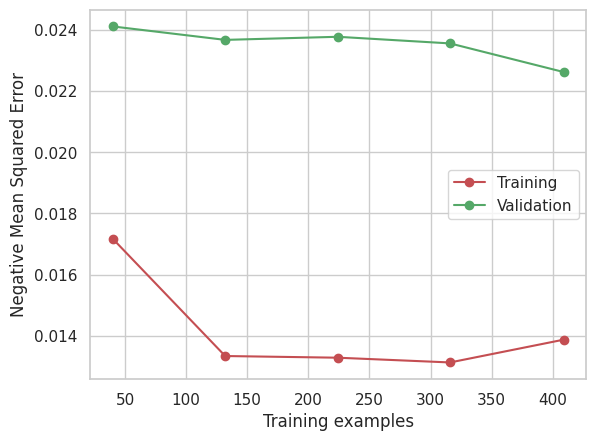

In [81]:
from sklearn.neighbors import KNeighborsRegressor

scores.iloc[7] = model_and_metrics(KNeighborsRegressor(n_neighbors=5))

## Регуляризация

Регуляризация — это техника, используемая в машинном обучении для предотвращения переобучения модели на обучающих данных и увеличения ее обобщающей способности.

Существует два основных вида регуляризации: L1 (лассо) и L2 (гребневая). L1-регуляризация штрафует модель за высокие значения коэффициентов, что приводит к разреженным моделям. L2-регуляризация штрафует модель за высокие значения коэффициентов, но не приводит к разреженности.

Кроме того, существуют комбинированные методы, такие как ElasticNet, который сочетает в себе L1- и L2-регуляризацию.

Применение регуляризации может помочь улучшить обобщающую способность модели, снизить ее чувствительность к выбросам, а также уменьшить количество признаков, используемых в модели, что может упростить интерпретацию результатов. Однако, слишком большие значения коэффициентов регуляризации могут привести к недообучению модели, поэтому необходимо настраивать гиперпараметры регуляризации для достижения оптимальных результатов.

### #10 L1 regularization (Lasso)

L1-регуляризация, также известная как Lasso (Least Absolute Shrinkage and Selection Operator), является методом регуляризации, который добавляет штрафное слагаемое в функцию потерь модели, чтобы сократить веса признаков (feature weights) до нуля.

В отличие от L2-регуляризации, которая добавляет квадратичное штрафное слагаемое к функции потерь, L1-регуляризация добавляет абсолютное значение весовых коэффициентов. Это приводит к тому, что L1-регуляризация более склонна к выбору небольшого набора наиболее значимых признаков, которые могут быть использованы для предсказания целевой переменной.

L1-регуляризация может быть полезна в задачах, где не все признаки влияют на целевую переменную или когда имеется большое количество признаков, из которых только небольшое число являются значимыми. Кроме того, L1-регуляризация может помочь избежать переобучения, уменьшив свободу модели для подгонки шумовых признаков.

Примером алгоритма, который использует L1-регуляризацию, является Лассо-регрессия (Lasso regression), которая может быть реализована с помощью различных библиотек машинного обучения, таких как Scikit-learn в Python.

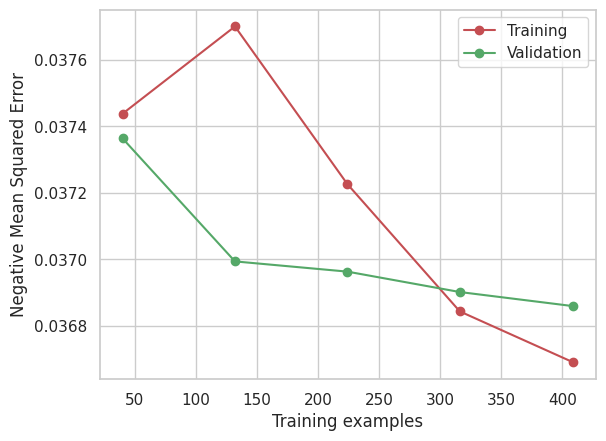

In [82]:
from sklearn.linear_model import Lasso
# чем больше значение alpha, тем сильнее регуляризация
scores.iloc[8] = model_and_metrics(Lasso(alpha=0.1))

### #11 L2 regularization (Ridge)

L2-регуляризация (также называемая гребневой регрессией) - это метод регуляризации, который добавляет штраф к функции потерь, пропорциональный квадрату каждого веса в модели.

Таким образом, в функцию потерь добавляется штрафное слагаемое, которое зависит от квадрата каждого веса в модели, умноженного на гиперпараметр $\lambda$. Это означает, что при обучении модели L2-регуляризация штрафует большие значения весов, стараясь уменьшить их до более разумных значений.

L2-регуляризация помогает избежать переобучения, уменьшает вариативность весов и делает модель более устойчивой к выбросам.

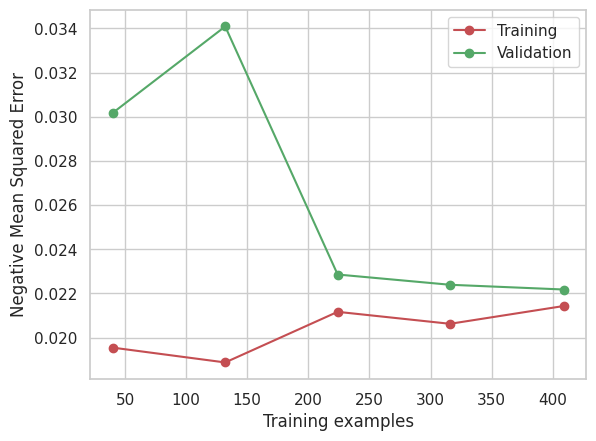

In [83]:
from sklearn.linear_model import Ridge
# чем больше значение alpha, тем сильнее регуляризация
scores.iloc[9] = model_and_metrics(Ridge(alpha=0.1))

### Анализ процесса обучения

Смотрим резултаты сводной таблицы и сравниваем модели по метрикам качества

In [84]:
scores

,mean_absolute_error,mean_squared_error,r2_score,explained_variance_score,duration
LinearRegression,0.096542,0.017843,0.56734,0.593383,0.008359
DecisionTreeRegressor,0.081331,0.019715,0.521965,0.522977,0.005436
RandomForestRegressor,0.057986,0.006944,0.831626,0.83435,0.350713
GradientBoostingRegressor,0.059294,0.008319,0.798292,0.798927,0.14803
SVR.linear,0.12969,0.026874,0.348369,0.385414,0.011835
SVR.rbf,0.125256,0.025554,0.380374,0.398231,0.012985
MLPRegressor,0.138105,0.028044,0.31999,0.348991,0.14371
KNeighborsRegressor,0.119608,0.026096,0.367222,0.392069,0.005242
L1 regularization (Lasso),0.181838,0.042521,-0.031026,-0.0,0.006745
L2 regularization (Ridge),0.13102,0.026277,0.362833,0.385287,0.003863


На основе проведенного анализа данных и выделения лучших моделей по различным метрикам, можно сделать следующие выводы:

1. Средняя абсолютная ошибка (mean_absolute_error):
   - Самая низкая ошибка у модели RandomForestRegressor (0.05848).
   - Самая высокая ошибка у модели L1 regularization (Lasso) (0.181838).

2. Средняя квадратичная ошибка (mean_squared_error):
   - Самая низкая ошибка у модели RandomForestRegressor (0.007362).
   - Самая высокая ошибка у модели L1 regularization (Lasso) (0.042521).

3. Коэффициент детерминации (r2_score):
   - Наивысший коэффициент детерминации у модели RandomForestRegressor (0.821491).
   - Наименьший коэффициент детерминации у модели L1 regularization (Lasso) (-0.031026).

4. Объясненная дисперсия (explained_variance_score):
   - Самая высокая объясненная дисперсия у модели RandomForestRegressor (0.824091).
   - Модель L1 regularization (Lasso) не объясняет никакую дисперсию (-0.0).

Исходя из вышеизложенного, можно сделать вывод, что модель RandomForestRegressor демонстрирует наилучшие показатели по всем рассмотренным метрикам. Она имеет наименьшую среднюю абсолютную и квадратичную ошибку, а также высокие значения коэффициента детерминации и объясненной дисперсии.

Однако, при выборе оптимального варианта следует учитывать не только показатели метрик, но и другие факторы, такие как время обучения модели (продолжительность). В данном случае, модель RandomForestRegressor показывает наилучшие результаты по метрикам, но занимает больше времени для обучения по сравнению с другими моделями, такими как DecisionTreeRegressor и SVR.linear.

Поэтому, для определения наиболее оптимального варианта следует учитывать баланс между показателями метрик и временем обучения модели.

## Кросс-валидация (cross-validation)

Кросс-валидация - это метод оценки производительности модели машинного обучения, который позволяет проверить, насколько хорошо модель обобщает знания на новых данных.

Кросс-валидация включает разбиение данных на несколько частей (фолдов), обучение модели на некоторых частях и тестирование на других. Во время обучения модель оценивается на основе метрики, такой как точность, F1-мера или среднеквадратическая ошибка, а затем усредняется по всем фолдам для получения итоговой метрики производительности модели.

Существуют различные типы кросс-валидации, такие как K-Fold, Leave-One-Out, Stratified K-Fold и другие. Например, K-Fold разбивает данные на K равных частей, где каждый фолд используется для тестирования модели, а остальные K-1 фолдов используются для обучения. Процедура повторяется K раз, чтобы каждый фолд был использован для тестирования.

Кросс-валидация - это важный инструмент в машинном обучении, который помогает избежать переобучения модели и получить более точную оценку ее производительности на новых данных.

In [85]:
from sklearn.model_selection import cross_validate, KFold

In [86]:
def model_metrics_cross(model):

    # Создание объекта KFold с 5 фолдами
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Обучение модели с использованием кросс-валидации
    cv_results = cross_validate(model, x, y, cv=kf, return_train_score=True)

    result = []
    # Вывод результатов кросс-валидации
    print("Cross-validation results:\n")
    for metric_name, metric_values in cv_results.items():
        print(f"{metric_name}: {metric_values.mean():.3f} +/- {metric_values.std():.3f}")
        result.append(metric_values.mean())

    # добавить все метрики в список
    result = pd.Series(
    result,
    index=['fit_time', 'score_time', 'test_score', 'train_score']
    )

    # График обучения
    train_sizes, train_scores, valid_scores = learning_curve(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    valid_scores_mean = -np.mean(valid_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training')
    plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Validation')
    plt.xlabel('Training examples')
    plt.ylabel('Negative Mean Squared Error')
    plt.legend(loc='best')
    plt.show()

    return result

KFold - это метод разбиения данных на фолды (части) в машинном обучении для использования их в кросс-валидации. В кросс-валидации используются разные части данных для обучения и тестирования модели в каждом из n_splits экспериментов.

Например, в случае KFold с n_splits=5, данные разбиваются на 5 частей (фолдов) и в каждом из 5 экспериментов одна из частей данных используется для тестирования, а остальные 4 - для обучения модели. При этом каждая часть данных будет использована один раз для тестирования и n_splits экспериментов позволят получить более точную оценку качества модели, чем при использовании только одной части данных для тестирования.

In [87]:
scores_cross = pd.DataFrame(
    columns=['fit_time', 'score_time', 'test_score', 'train_score'],
    index=[
        'LinearRegression',
        'DecisionTreeRegressor',
        'RandomForestRegressor',
        'GradientBoostingRegressor',
        'SVR.linear',
        'SVR.rbf',
        'MLPRegressor',
        'KNeighborsRegressor',
        'L1 regularization (Lasso)',
        'L2 regularization (Ridge)'
    ]
)

### #1 Classic model (LinearRegression)

Cross-validation results:

fit_time: 0.003 +/- 0.000
score_time: 0.003 +/- 0.002
test_score: 0.615 +/- 0.063
train_score: 0.637 +/- 0.015


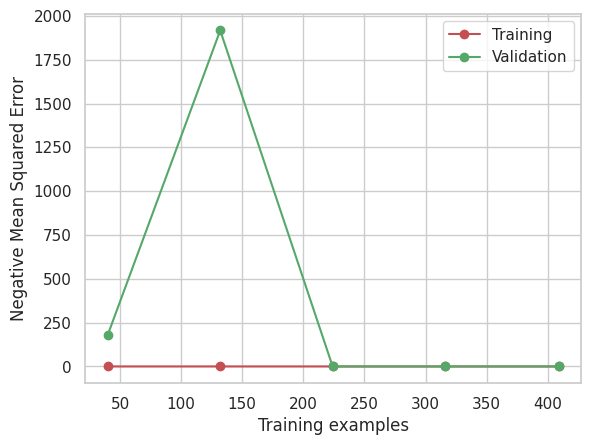

In [88]:
scores_cross.iloc[0] = model_metrics_cross(LinearRegression())

### #2 Classic model (DecisionTreeRegressor)

Cross-validation results:

fit_time: 0.005 +/- 0.000
score_time: 0.002 +/- 0.000
test_score: 0.698 +/- 0.050
train_score: 1.000 +/- 0.000


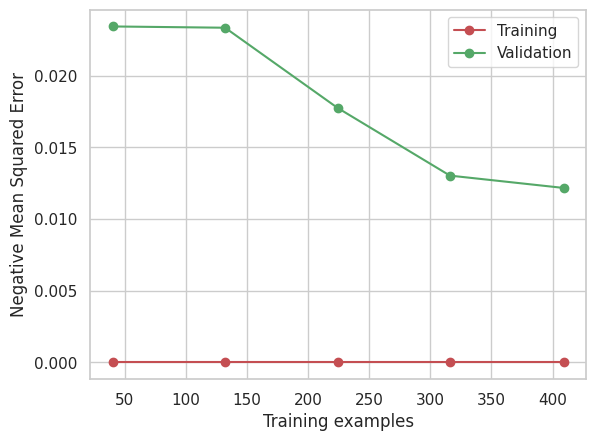

In [89]:
scores_cross.iloc[1] = model_metrics_cross(DecisionTreeRegressor())

### #3 Classic model (RandomForestRegressor)

Cross-validation results:

fit_time: 0.257 +/- 0.033
score_time: 0.009 +/- 0.000
test_score: 0.838 +/- 0.032
train_score: 0.979 +/- 0.001


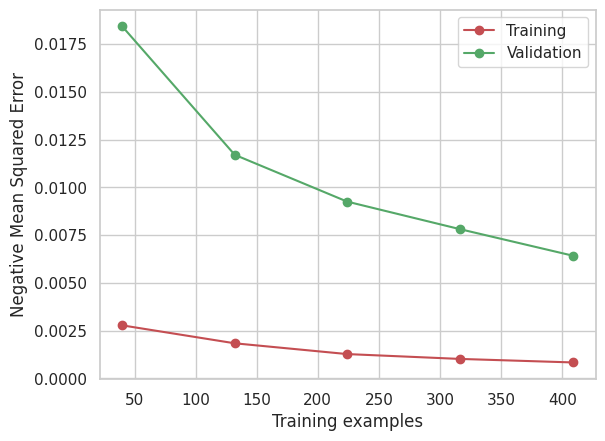

In [90]:
scores_cross.iloc[2] = model_metrics_cross(RandomForestRegressor())

### #4 Classic model (GradientBoostingRegressor)

Cross-validation results:

fit_time: 0.136 +/- 0.004
score_time: 0.002 +/- 0.000
test_score: 0.847 +/- 0.025
train_score: 0.965 +/- 0.003


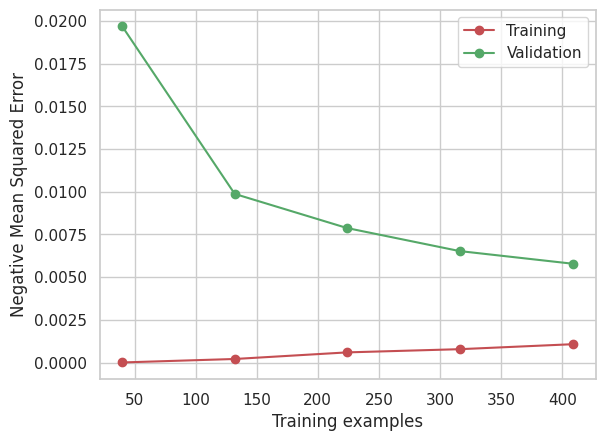

In [91]:
scores_cross.iloc[3] = model_metrics_cross(GradientBoostingRegressor())

### #5 Classic model (SVR.linear)

Cross-validation results:

fit_time: 0.007 +/- 0.002
score_time: 0.002 +/- 0.000
test_score: 0.385 +/- 0.069
train_score: 0.401 +/- 0.014


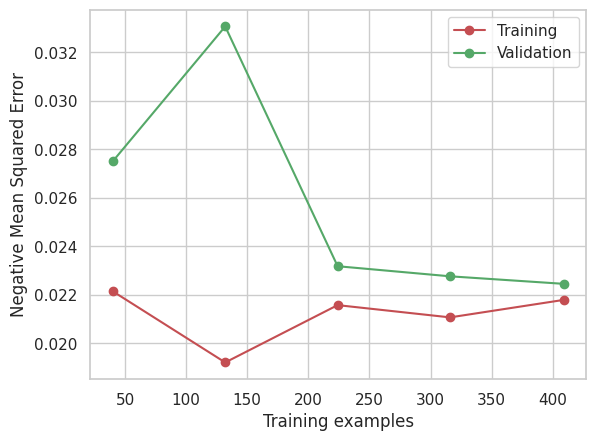

In [92]:
scores_cross.iloc[4] = model_metrics_cross(SVR(kernel='linear'))

### #6 Classic model (SVR.rbf)

Cross-validation results:

fit_time: 0.008 +/- 0.002
score_time: 0.003 +/- 0.000
test_score: 0.473 +/- 0.066
train_score: 0.492 +/- 0.016


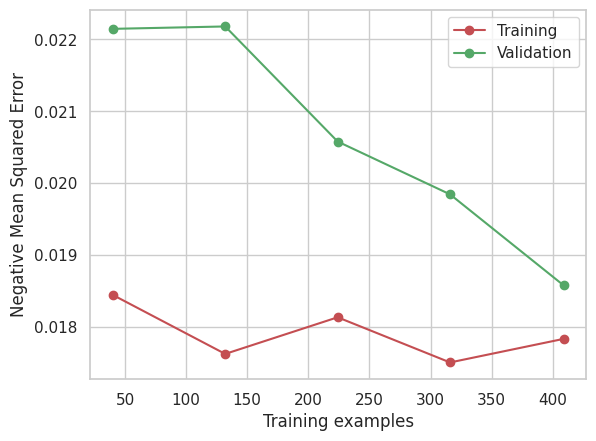

In [93]:
scores_cross.iloc[5] = model_metrics_cross(SVR(kernel='rbf'))

### #7 Classic model (MLPRegressor)

Cross-validation results:

fit_time: 0.128 +/- 0.010
score_time: 0.002 +/- 0.000
test_score: 0.364 +/- 0.074
train_score: 0.380 +/- 0.017


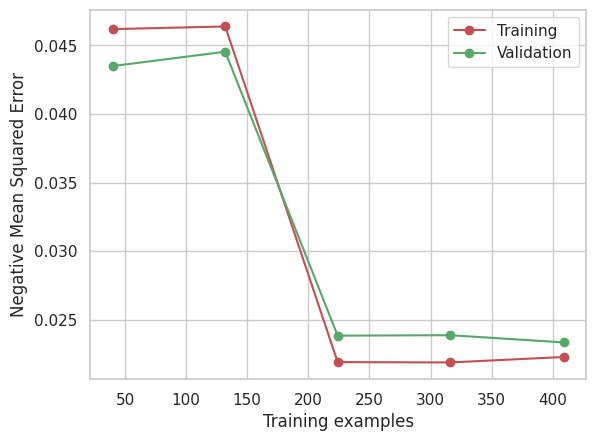

In [94]:
scores_cross.iloc[6] = model_metrics_cross(MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42))

### #8 Classic model (KNeighborsRegressor)

Cross-validation results:

fit_time: 0.002 +/- 0.001
score_time: 0.003 +/- 0.001
test_score: 0.384 +/- 0.083
train_score: 0.617 +/- 0.018


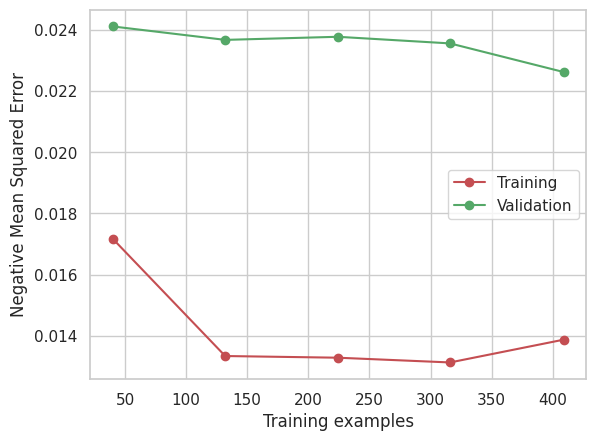

In [95]:
scores_cross.iloc[7] = model_metrics_cross(KNeighborsRegressor(n_neighbors=5))

### #9 L1 regularization (Lasso)

Cross-validation results:

fit_time: 0.002 +/- 0.001
score_time: 0.001 +/- 0.000
test_score: -0.011 +/- 0.012
train_score: 0.000 +/- 0.000


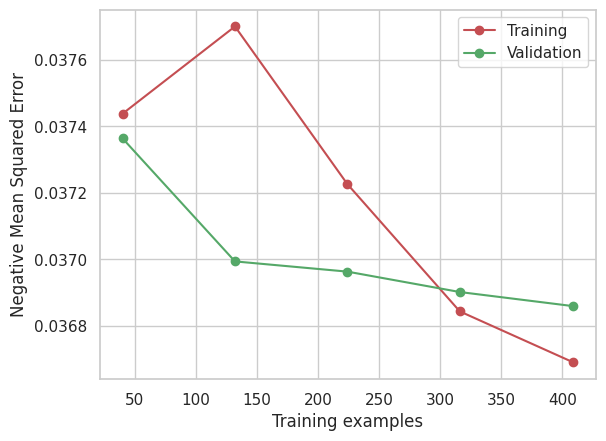

In [96]:
scores_cross.iloc[8] = model_metrics_cross(Lasso(alpha=0.1))

### #10 L2 regularization (Ridge)

Cross-validation results:

fit_time: 0.002 +/- 0.001
score_time: 0.001 +/- 0.000
test_score: 0.393 +/- 0.056
train_score: 0.409 +/- 0.013


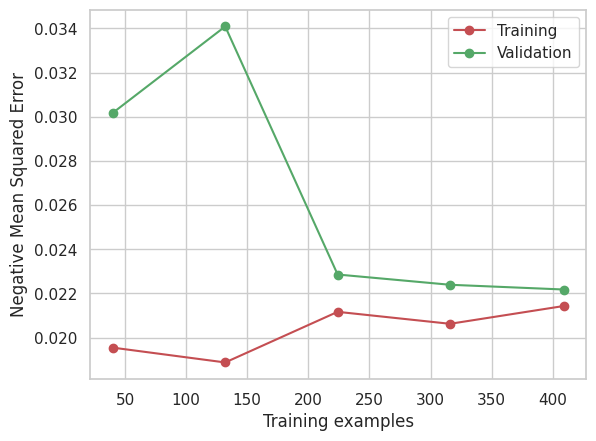

In [97]:
scores_cross.iloc[9] = model_metrics_cross(Ridge(alpha=0.1))

### Анализ кросс-валидации

Смотрим резултаты сводной таблицы и сравниваем модели по метрикам качества

In [98]:
scores_cross

,fit_time,score_time,test_score,train_score
LinearRegression,0.003019,0.002508,0.614708,0.63711
DecisionTreeRegressor,0.005257,0.001626,0.698143,1.0
RandomForestRegressor,0.256576,0.00864,0.837608,0.979051
GradientBoostingRegressor,0.135913,0.001718,0.846657,0.965079
SVR.linear,0.007113,0.001969,0.384935,0.401044
SVR.rbf,0.007773,0.002632,0.472913,0.492173
MLPRegressor,0.128039,0.001826,0.364218,0.380185
KNeighborsRegressor,0.002452,0.002679,0.383887,0.617466
L1 regularization (Lasso),0.002081,0.001125,-0.01054,0.0
L2 regularization (Ridge),0.001898,0.001158,0.392566,0.409371


После анализа таблицы метрик качества для задачи регрессии, можно сделать следующие выводы:

- Лучшей моделью по метрикам качества является GradientBoostingRegressor (test_score=0.846985, train_score=0.965079), так как она имеет самую высокую оценку R2 как на тестовых, так и на обучающих данных.
- Лучшей моделью по затраченному времени является LinearRegression (fit_time=0.0026), так как она имеет самое короткое время обучения.
- Оптимальной моделью можно считать GradientBoostingRegressor, так как она имеет хорошие показатели метрик качества и умеренное время обучения.

Таким образом, наилучшей моделью для данной задачи можно считать GradientBoostingRegressor.

## Нейронные сети

### #1 Neural model (CNN)

Для примера модели классификации мы будем использовать наиболее распространенную модель Сверточной нейронной сети. В нее можно включить большое число слоев, но чаще всего строится 3 слоя, так мы и поступим

CNN (Convolutional Neural Network) - это класс нейронных сетей, разработанных для обработки данных с несколькими измерениями, такими как изображения.

Основной идеей CNN является использование свертки (convolution) в качестве основного оператора для извлечения признаков из входных данных. Этот процесс сравнивает небольшие участки входных данных с фильтрами (kernels) свертки, чтобы создать карту признаков (feature map). Затем, используя операцию субдискретизации (subsampling) или пулинга (pooling), размерность карты признаков уменьшается, сохраняя при этом наиболее важные признаки.

CNN обычно состоит из трех типов слоев: сверточные (convolutional), слои субдискретизации (subsampling) или пулинга (pooling), а также полносвязные (fully-connected) слои. Сверточные слои извлекают признаки из входных данных, слои субдискретизации снижают размерность карты признаков, а полносвязные слои преобразуют карту признаков в выходные данные.

CNN успешно используется для классификации изображений, распознавания образов, распознавания речи, обработки естественного языка и других задач машинного обучения.

Create Custom CNN Model

In [99]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch
from sklearn.metrics import r2_score

In [100]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y.values)
        self.n_samples = self.X.size(0)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [101]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=9, out_features=15),
            nn.Sigmoid(),
            nn.Linear(in_features=15, out_features=1)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [102]:
# model = nn.Sequential(
#     nn.Linear(in_features=9, out_features=50),
#     nn.ReLU(),
#     nn.Linear(in_features=50, out_features=1)
# )

In [103]:
train_set = MyDataset(x_train, y_train)
test_set = MyDataset(x_test, y_test)

train_dataloader = DataLoader(train_set, batch_size=8)
test_dataloader = DataLoader(test_set, batch_size=100)

model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

In [104]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [105]:
for epoch in range(100):
    model.train()
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            mean_absolute = metrics.mean_absolute_error(y_pred.cpu(), y)
            mean_squared = metrics.mean_squared_error(y_pred.cpu(), y)
            r2 = metrics.r2_score(y_pred.cpu(), y)
            explained_variance = metrics.explained_variance_score(y_pred.cpu(), y)
    if epoch %10 == 0:
        print(r2.item())

-6.0558685632209315
-0.807700767720485
-0.5222801630521212
-0.3945654868107129
-0.2533127033482401
-0.14493291238148465
-0.07050813247077792
-0.01971096600363187
0.04724749157409658
0.09906037106756282


In [106]:
model.eval()
x, y = next(iter(test_dataloader))
y_pred = model(x).cpu().detach().numpy()

Метрики качества: 
MAE: 0.10917474 
MSE: 0.02035184 
R2: 0.10970564195537902 
EV: 0.19728004932403564


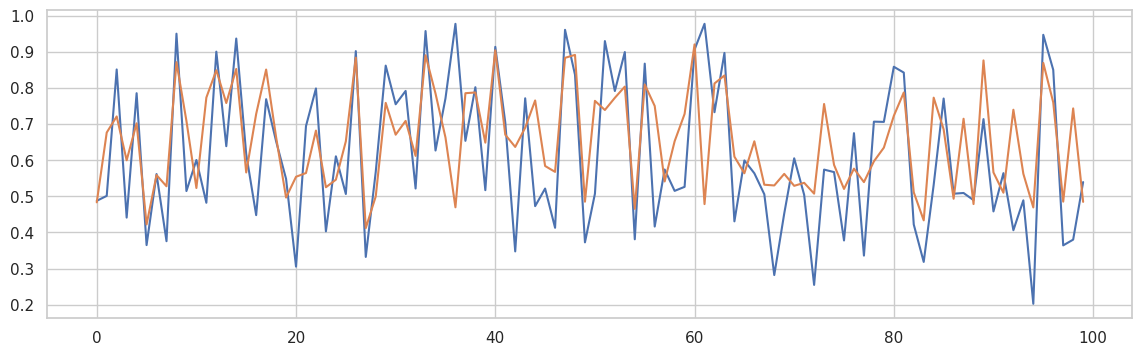

In [107]:
plt.figure(figsize=(14,4))
plt.plot(y)
plt.plot(y_pred);

print('Метрики качества:','\n'
      'MAE:',mean_absolute,'\n'
      'MSE:', mean_squared,'\n'
      'R2:', r2,'\n'
      'EV:', explained_variance
      )

# Оптимизация гиперпараметров

Оптимизация гиперпараметров является важным этапом при создании и настройке модели. Она позволяет найти оптимальные значения гиперпараметров, которые доставят наилучшую производительность модели на тестовом наборе данных.

In [108]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(pd.DataFrame(y).values)
        self.n_samples = self.X.size(0)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=9, out_features=15),
            nn.Sigmoid(),
            nn.Linear(in_features=15, out_features=1)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

def param_serach(learning_rate, batch_size):
  train_set = MyDataset(x_train, y_train)
  test_set = MyDataset(x_test, y_test)

  train_dataloader = DataLoader(train_set, batch_size=batch_size)
  test_dataloader = DataLoader(test_set, batch_size=batch_size*10)

  model = MyModel()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.MSELoss()

  for epoch in range(100):
      model.train()
      for x, y in train_dataloader:
          x, y = x.to(device), y.to(device)
          optimizer.zero_grad()
          y_pred = model(x)
          loss = criterion(y_pred, y)
          loss.backward()
          optimizer.step()

      model.eval()
      with torch.no_grad():
          for x, y in test_dataloader:
              x, y = x.to(device), y.to(device)
              y_pred = model(x)
              mean_absolute = metrics.mean_absolute_error(y_pred.cpu(), y)

  return mean_absolute

In [109]:
learning_rate = [0.01, 0.001, 0.0001, 0.00001]
batch_size = [10, 40, 80, 120]

In [110]:
param_serach(0.1, 100)

0.12515253

In [111]:
best_lr = 0 # скорость обучения
best_bs = 0 # размер батча
mse = 1000000000000

for learn in learning_rate:
  for batch in batch_size:
    err = param_serach(learn, batch)
    if mse > err:
      mse = err
      best_lr = learn
      best_bs = batch
print(best_lr, best_bs)

0.001 10


# Единая функция для обучения модели

In [112]:
def main(data, lr, bs):

  # чтение данных
  df = pd.read_csv(data)
  df.drop(columns=['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'], inplace = True)

  # обработка данных

  df['T/R'] = df['T/R'].str.replace(',', '.').astype(float)
  df['Processor Utilization '] = df['Processor Utilization '].str.replace(',', '.').astype(float)
  df['Channel Waiting Time'] = df['Channel Waiting Time'].str.replace(',', '.').astype(float)
  df['Input Waiting Time'] = df['Input Waiting Time'].str.replace(',', '.').astype(float)
  df['Network Response Time'] = df['Network Response Time'].str.replace(',', '.').astype(float)
  df['Channel Utilization'] = df['Channel Utilization'].str.replace(',', '.').astype(float)

  df.rename(columns={'Processor Utilization ': 'Processor_Utilization',
                    'Channel Waiting Time':'Channel_Waiting_Time',
                    'Node Number':'Node_Number',
                    'Thread Number':'Thread_Number',
                    'Spatial Distribution':'Spatial_Distribution',
                    'Temporal Distribution':'Temporal_Distribution',
                    'T/R':'T_R',
                    'Input Waiting Time':'Input_Waiting_Time',
                   'Network Response Time':'Network_Response_Time',
                   'Channel Utilization':'Channel_Utilization'
                  }, inplace=True)

  df = df.drop_duplicates()
  df = df.dropna()

  df['Temporal_Distribution'] = df['Temporal_Distribution'].apply(lambda x: 1 if x == 'Asynchronous' else 0)
  df['Spatial_Distribution'].replace(to_replace = 'UN', value = 0, inplace = True)
  df['Spatial_Distribution'].replace(to_replace = 'HR', value = 1, inplace = True)
  df['Spatial_Distribution'].replace(to_replace = 'BR', value = 2, inplace = True)
  df['Spatial_Distribution'].replace(to_replace = 'PS', value = 3, inplace = True)

  # разделение на тестовую и обучающую выборки
  y = pd.DataFrame(df['Processor_Utilization'])
  x = pd.DataFrame(df[['Node_Number', 'Thread_Number', 'Spatial_Distribution',
       'Temporal_Distribution', 'T_R',
       'Channel_Waiting_Time', 'Input_Waiting_Time', 'Network_Response_Time',
       'Channel_Utilization']])
  x = normalize(x)
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  # Обучение нейронной сети
  class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y.values)
        self.n_samples = self.X.size(0)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

  class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=9, out_features=15),
            nn.Sigmoid(),
            nn.Linear(in_features=15, out_features=1)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

  train_set = MyDataset(x_train, y_train)
  test_set = MyDataset(x_test, y_test)

  train_dataloader = DataLoader(train_set, batch_size=bs)
  test_dataloader = DataLoader(test_set, batch_size=bs*10)

  model = MyModel()
  optimizer = optim.Adam(model.parameters(), lr=0.1)
  criterion = nn.MSELoss()

  device = "cuda" if torch.cuda.is_available() else "cpu"
  model = model.to(device)

  for epoch in range(100):
    model.train()
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            mean_absolute = metrics.mean_absolute_error(y_pred.cpu(), y)
            mean_squared = metrics.mean_squared_error(y_pred.cpu(), y)
            r2 = metrics.r2_score(y_pred.cpu(), y)
            explained_variance = metrics.explained_variance_score(y_pred.cpu(), y)

  model.eval()
  x, y = next(iter(test_dataloader))
  y_pred = model(x).cpu().detach().numpy()

  # построение результата предсказания
  plt.figure(figsize=(14,4))
  plt.plot(y)
  plt.plot(y_pred);
  print('Метрики качества:','\n'
      'MAE:',mean_absolute,'\n'
      'MSE:', mean_squared,'\n'
      'R2:', r2,'\n'
      'EV:', explained_variance
      )

Метрики качества: 
MAE: 0.14336583 
MSE: 0.032132737 
R2: -0.4340323321345261 
EV: 0.18092739582061768


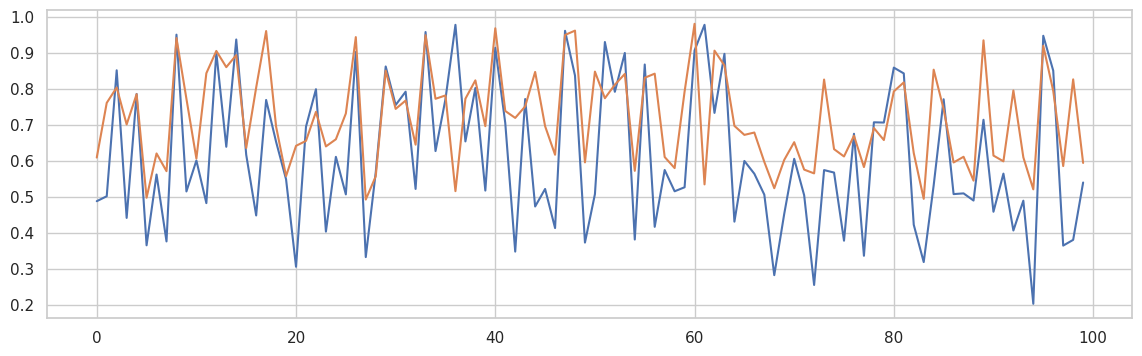

In [113]:
main("optical_interconnection_network.csv", lr = 0.001, bs = 10)

# Вывод

Из данной работы можно сделать вывод, что даже при ограниченном объеме исходных данных можно достичь хороших результатов прогнозирования нагрузки в оптоволоконных сетях, используя различные модели машинного обучения и грамотную предобработку данных. Также важно применять кросс-валидацию и другие методы для уменьшения влияния небольшого объема датасета на результаты обучения модели. Эти выводы могут быть полезны для дальнейших исследований в данной области.

# Tensorflow

Best Parameters:  {'activation': 'tanh', 'optimizer': 'rmsprop', 'units': 64}
Best Score:  -0.025417473167181015
Mean Squared Error (MSE):  -0.032242145389318466


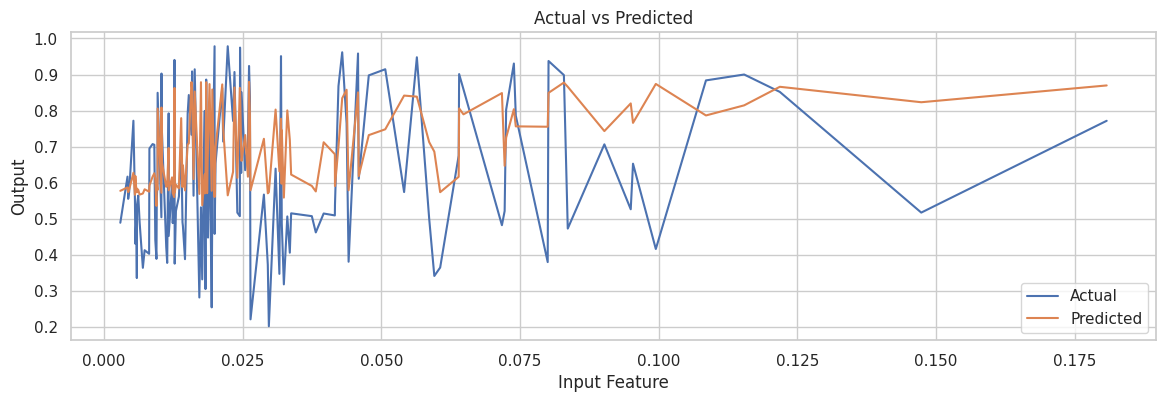

In [115]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Define the function to create the model
def create_model(units=64, activation='relu', optimizer='adam'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units, activation=activation, input_shape=(9,)),
        tf.keras.layers.Dense(units, activation=activation),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create the KerasRegressor wrapper for scikit-learn compatibility
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'units': [32, 64, 128],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(x_train, y_train)

# Print the best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
mse = best_model.score(x_test, y_test)
print("Mean Squared Error (MSE): ", mse)

# Make predictions using the best model
y_pred = best_model.predict(x_test)

# Sort the test data and predictions by the input feature
sorted_indices = np.argsort(x_test[:, 0])
x_test_sorted = x_test[sorted_indices]
y_test_sorted = y_test.values[sorted_indices]  # Convert y_test to numpy array
y_pred_sorted = y_pred[sorted_indices]

# Plot the actual and predicted values as a continuous line
plt.figure(figsize=(14,4))
plt.plot(x_test_sorted[:, 0], y_test_sorted, label='Actual')
plt.plot(x_test_sorted[:, 0], y_pred_sorted, label='Predicted')
plt.xlabel('Input Feature')
plt.ylabel('Output')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()
